In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
# from tensorflow.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings
import numpy as np
import pandas as pd
from collections import Counter
warnings.filterwarnings("ignore")
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.95
# config.gpu_options.visible_device_list = "0"
# set_session(tf.Session(config=config))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

python 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
keras version 3.6.0
tensorflow version 2.17.0


In [2]:
import pandas as pd
from PIL import Image
import os

# Load the CSV file with image IDs and captions
captions_df = pd.read_csv("D:/PhD file/image caption/PhD datasets/Total_cancer_image_caption/medical_image_captions.csv")

# Specify the directory where your images are stored
image_dir = 'D:/PhD file/image caption/PhD datasets/Total_cancer_image_caption/images/'  # Replace with the correct path to your images

# Iterate through the DataFrame to load each image and its caption
for index, row in captions_df.iterrows():
    image_id = row['image_id']
    caption = row['caption']
    
    # Construct the image file path
    image_path = os.path.join(image_dir, image_id)
    
    # Check if the image exists
    if os.path.exists(image_path):
        # Open the image using PIL
        image = Image.open(image_path)
        
    #     # Display the image and the corresponding caption
    #     image.show()  # This will open the image in the default viewer
    #     print(f"Caption for {image_id}: {caption}")
    # else:
    #     print(f"Image {image_id} not found.")


## Preliminary analysis.
Import caption data

Load the text data and save it into a panda dataframe df_txt.

 - image_id : jpg file name
 - caption_id : unique ID for each caption for the same image
 - caption : string of caption, all in lower case

In [3]:
import numpy as np
from collections import Counter

# Replace 'filename' with the actual column name for image identifiers
uni_filenames = np.unique(captions_df['image_id'].values)
print("The number of unique file names: {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
print(Counter(Counter(captions_df['image_id'].values).values()))


The number of unique file names: 523
The distribution of the number of captions for each image:
Counter({5: 352, 6: 44, 4: 32, 7: 30, 10: 16, 8: 12, 3: 10, 9: 10, 1: 4, 11: 4, 12: 2, 2: 2, 14: 2, 15: 1, 13: 1, 22: 1})


In [4]:
print(captions_df.columns)

Index(['image_id', 'caption_id', 'caption'], dtype='object')


#### Let's have a look at some of the pictures together with the captions.

The 5 captions for each image share many common words and very similar meaning. Some sentences finish with "." but not all.

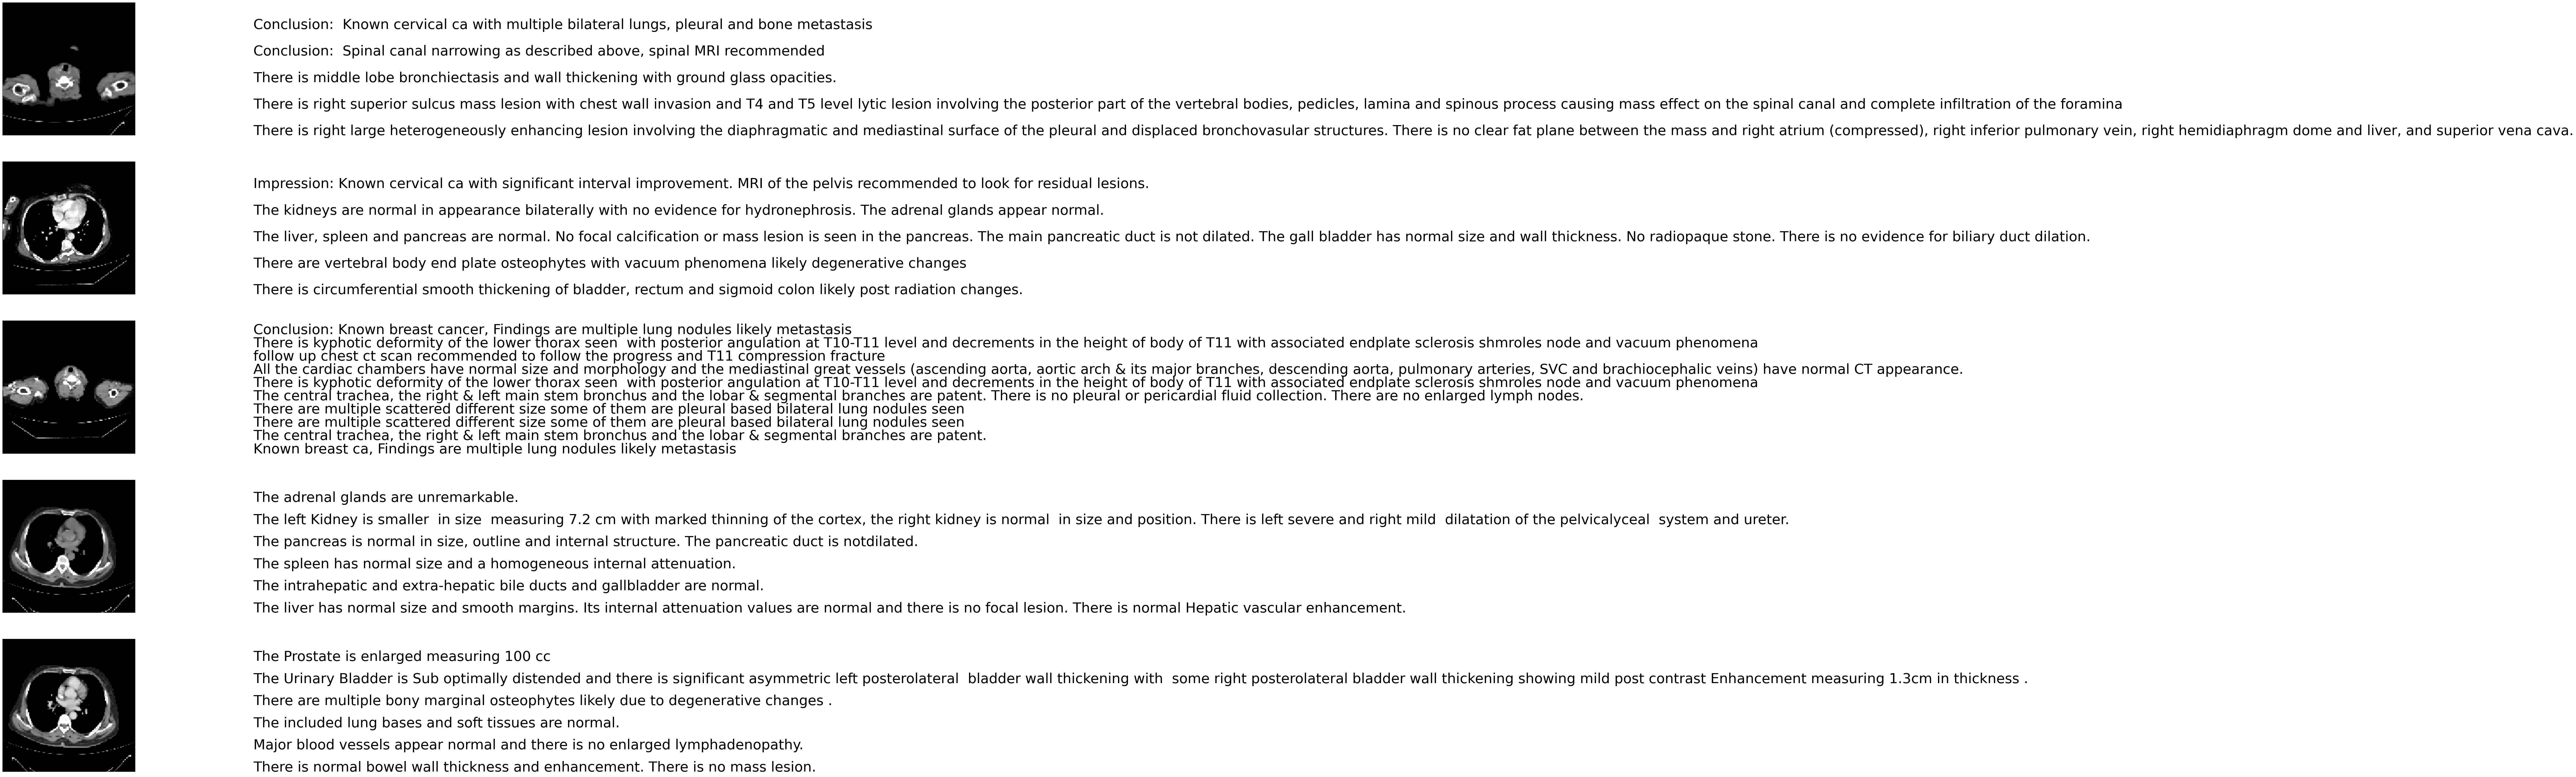

In [5]:
from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(30,40))
for jpgfnm in uni_filenames[:npic]:
    filename = image_dir + '/' + jpgfnm
    captions = list(captions_df["caption"].loc[captions_df["image_id"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=40)
    count += 1
plt.show()

## Data preparation

We prepare text and image data separately.

### Text preparation¶

We create a new dataframe dfword to visualize distribution of the words. It contains each word and its frequency in the entire tokens in decreasing order.

In [6]:
from collections import Counter
import pandas as pd

def df_word(captions_df):
    vocabulary = []
    for txt in captions_df.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values("count", ascending=False)  # Use sort_values() instead of sort()
    dfword = dfword.reset_index()[["word","count"]]
    return dfword

dfword = df_word(captions_df)
dfword.head(3)

Vocabulary Size: 5176


word  count
0  and   3118
1  the   2202
2   is   1904

### The most and least frequently appearing words¶

The most common words are articles such as "a", or "the", or punctuations.

These words do not have much infomation about the data.

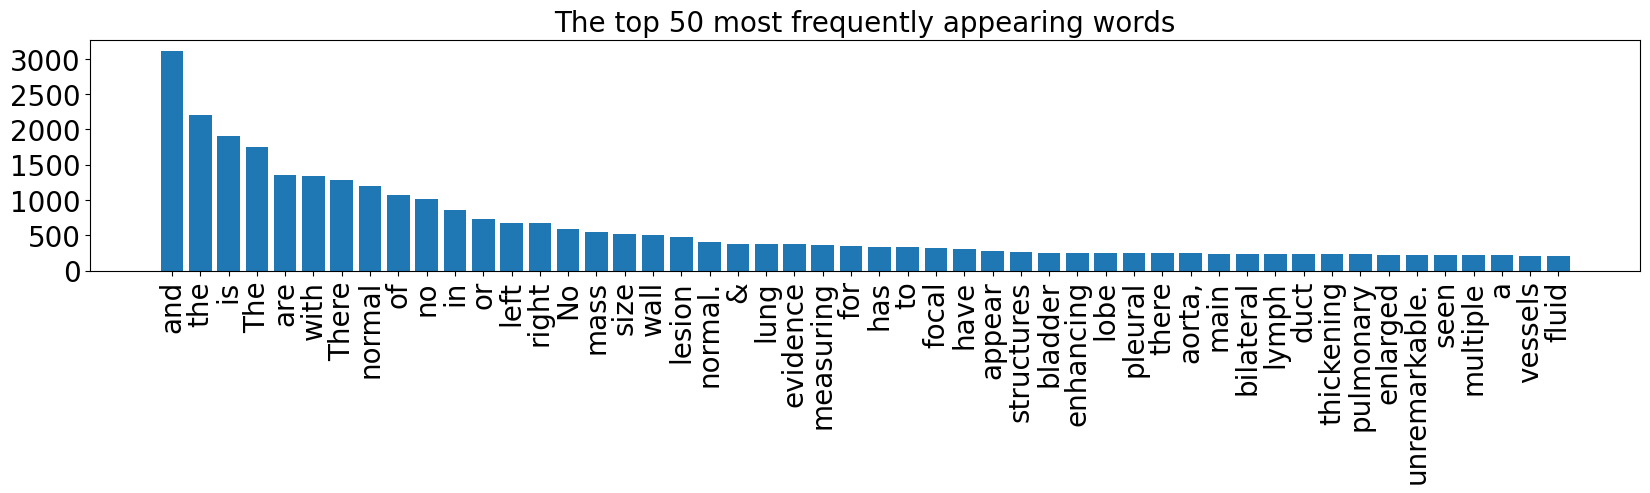

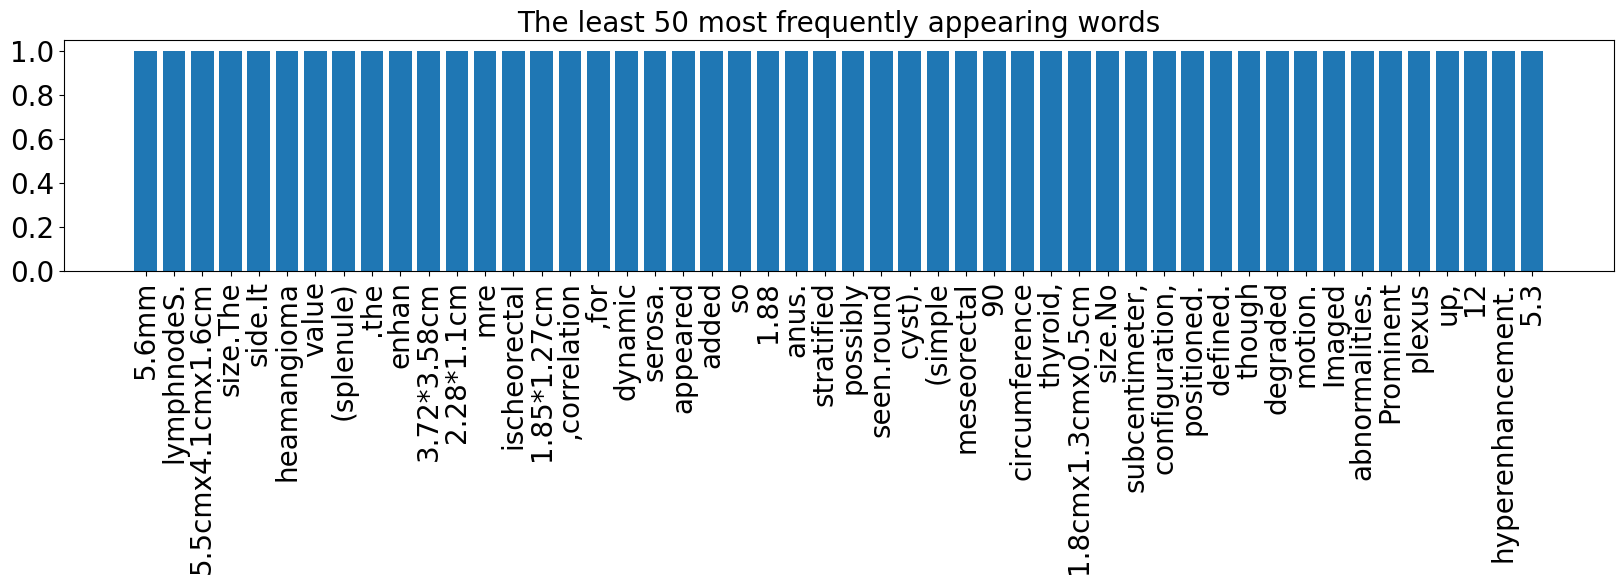

In [7]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")


In order to clean the caption,I will create three functions that:

- remove punctuation
- remove single character
- remove numeric characters

To see how these functions work, I will process a single example string using these three functions

In [8]:
import string
text_original = "I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me"

print("Origial sentense: ",text_original)
print("\nRemoving Punctuations...")

# creating a function that removes punctuation in the sentences
def remove_punctuation(text_original):
    text_without_punct = text_original.translate(str.maketrans('','',string.punctuation))
    return text_without_punct

text_without_punct = remove_punctuation(text_original)
print(text_without_punct)

print("\nRemoving a single character...")

# creating a function that removes single character
def removing_single_char(text):
    text_len_greater_than_one = ""
    for word in text.split():
        if len(word) > 1:
            text_len_greater_than_one += " " + word
    return text_len_greater_than_one

text_len_greater_than_one = removing_single_char(text_without_punct)
print(text_len_greater_than_one)

print("\nRemoving numeric values...")

# creating a function that removes numerical values
def remove_numeric(text, printTF=False):
    text_without_num = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("     {:10} : {:}".format(word, isalpha))
        if isalpha:
            text_without_num += " "+ word
    return text_without_num

text_without_num = remove_numeric(text_len_greater_than_one, printTF=True)
print(text_without_num)

Origial sentense:  I ate 8 burgers and 4 pizzas. it's 9:44 am. can you play chess with me

Removing Punctuations...
I ate 8 burgers and 4 pizzas its 944 am can you play chess with me

Removing a single character...
 ate burgers and pizzas its 944 am can you play chess with me

Removing numeric values...
     ate        : True
     burgers    : True
     and        : True
     pizzas     : True
     its        : True
     944        : False
     am         : True
     can        : True
     you        : True
     play       : True
     chess      : True
     with       : True
     me         : True
 ate burgers and pizzas its am can you play chess with me


**Clean all captions**

Using the three functions, I will clean all captions.

In [9]:
import string

# Define the remove_punctuation function
def remove_punctuation(text_original):
    translation_table = str.maketrans("", "", string.punctuation)
    text_no_punctuation = text_original.translate(translation_table)
    return text_no_punctuation

# Define the remove_single_character function
def remove_single_character(text):
    text_len_more_than1 = " ".join([word for word in text.split() if len(word) > 1])
    return text_len_more_than1

# Define the remove_numeric function
def remove_numeric(text):
    text_no_numeric = " ".join([word for word in text.split() if word.isalpha()])
    return text_no_numeric

# Define the text_clean function
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return text

# Assuming df_txt is defined somewhere in your code
for i, caption in enumerate(captions_df.caption.values):
    newcaption = text_clean(caption)
    captions_df["caption"].iloc[i] = newcaption


##### After cleaning, the vocabularly size get reduced by about 200.

Vocabulary Size: 3377


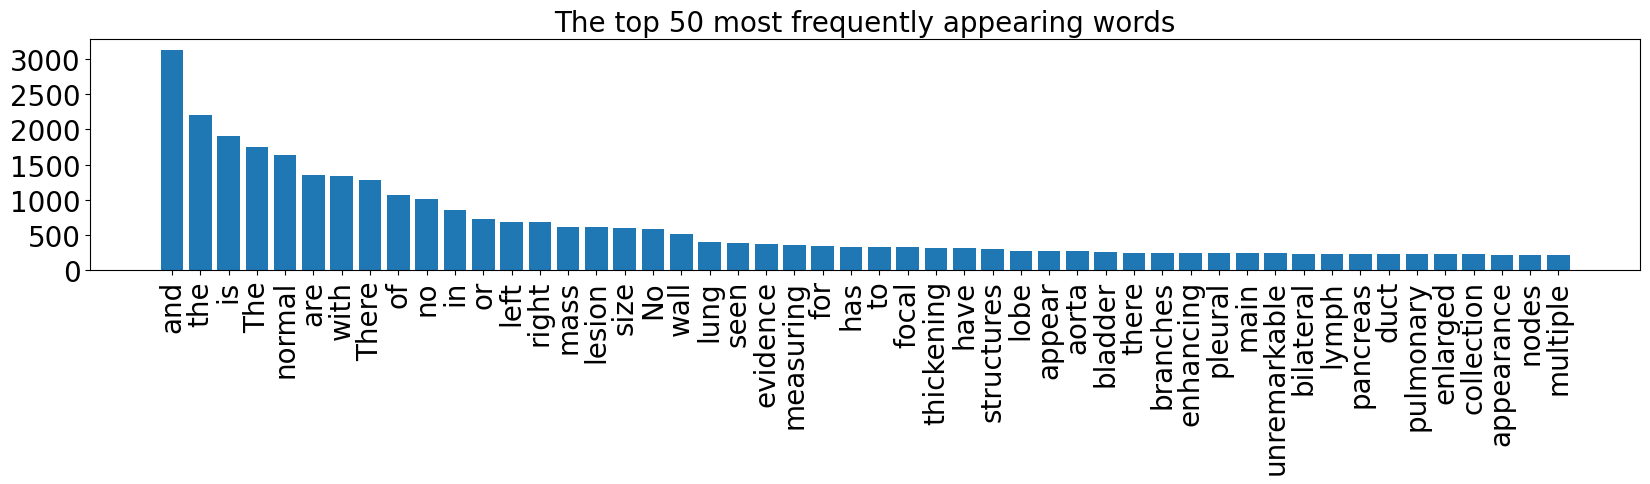

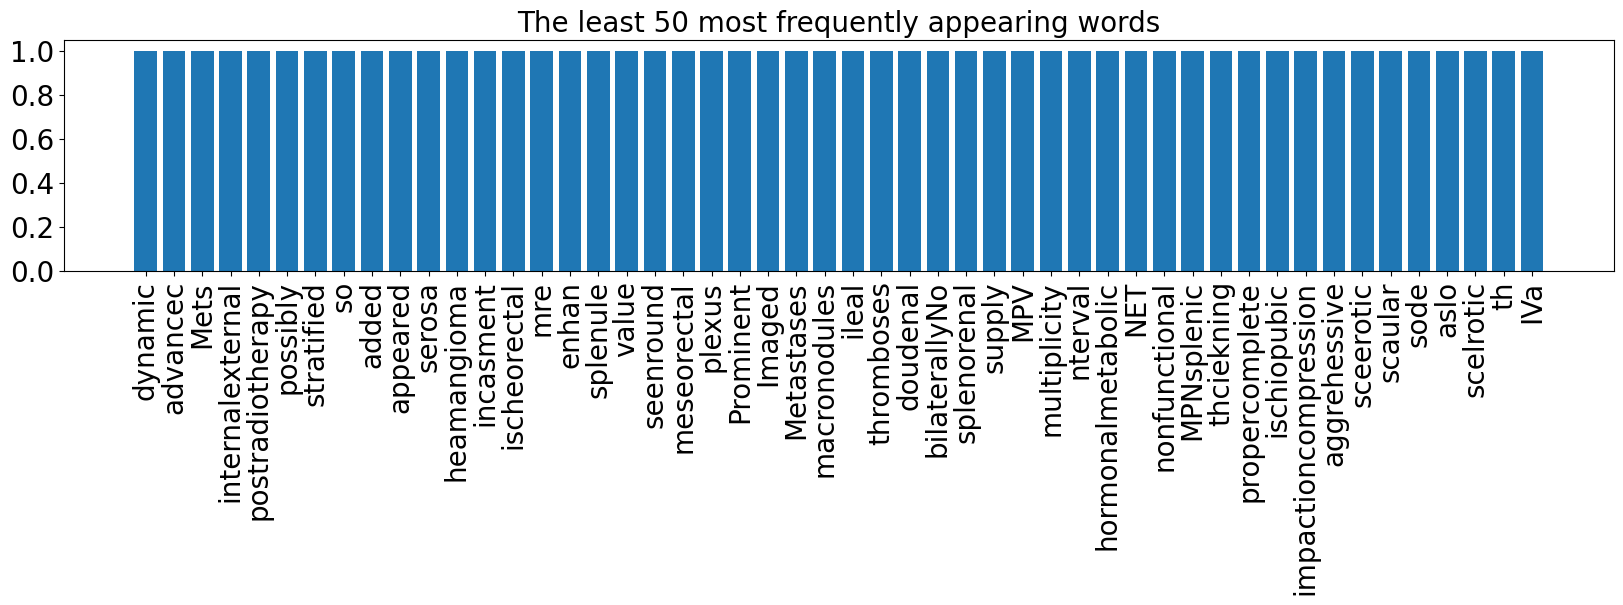

In [10]:
dfword = df_word(captions_df)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

**Add start and end sequence tokens¶**

In [11]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(captions_df)
df_txt0["caption"] = add_start_end_seq_token(captions_df["caption"])
df_txt0.head(5)
del captions_df

## **Image preparation**

**Create features for each image using VGG16's pre-trained networks**

Read in the pre-trained network. Notice that this network takes input of size (224,224,3). The output layer contains 1,000 nodes

In [12]:
from keras.applications import VGG16

modelvgg = VGG16(include_top=True,weights=None)
## load the locally saved weights
modelvgg.load_weights("vgg16_weights_tf_dim_ordering_tf_kernels (1).h5")
modelvgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

VGG16 is developed to classify images into 1,000 different classes. As I am not using VGG16 for the sake of the classification but I just need it for extracting features, I will remove the last layer from the network.

In [13]:
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
## show the deep learning model
modelvgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

### **images**

In [14]:
jpgs = os.listdir(image_dir)
print("The number of jpg flies in Medical_image _caption: {}".format(len(jpgs)))

The number of jpg flies in Medical_image _caption: 530


In [15]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
data = np.zeros((len(jpgs),npix,npix,3))
for i,name in enumerate(jpgs):
    # load an image from file
    filename = image_dir + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)

    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 891ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/s

**Visualization of the VGG16 features**

For each image, 4096 features are created. As I cannot visualize the 4096 dimensional space, I will create 2 dimentional representation of the space using PCA and visualize the distribution of the sample images.

In [16]:
import numpy as np
from sklearn.decomposition import PCA

# Assuming images is a dictionary-like object containing numeric data
encoder_values = np.array(list(images.values()))

# Check the shape of the data
print("Shape of encoder_values:", encoder_values.shape)

# Reshape if necessary (e.g., if it's not 2D)
# encoder_values = encoder_values.reshape(-1, 1)

# Create PCA instance
pca = PCA(n_components=2)

# Fit and transform the data
y_pca = pca.fit_transform(encoder_values)


Shape of encoder_values: (530, 1000)


**Do photo features make sense?¶**

I manually selected similar images that are creating clusters. Namely I created red, green, magenta, blue, yellow and purple clusters. From each cluster, I plotted the original images. As you see, images from the same clusters tend to be very similar:

- red: brestcancer
- green: colonalcaner
- magenta: cervical cancer
- blue: lungcancer
- yellow: not sure what these are?? I see many pictures are densely clustered around this area and

Photo features seem to make sense!

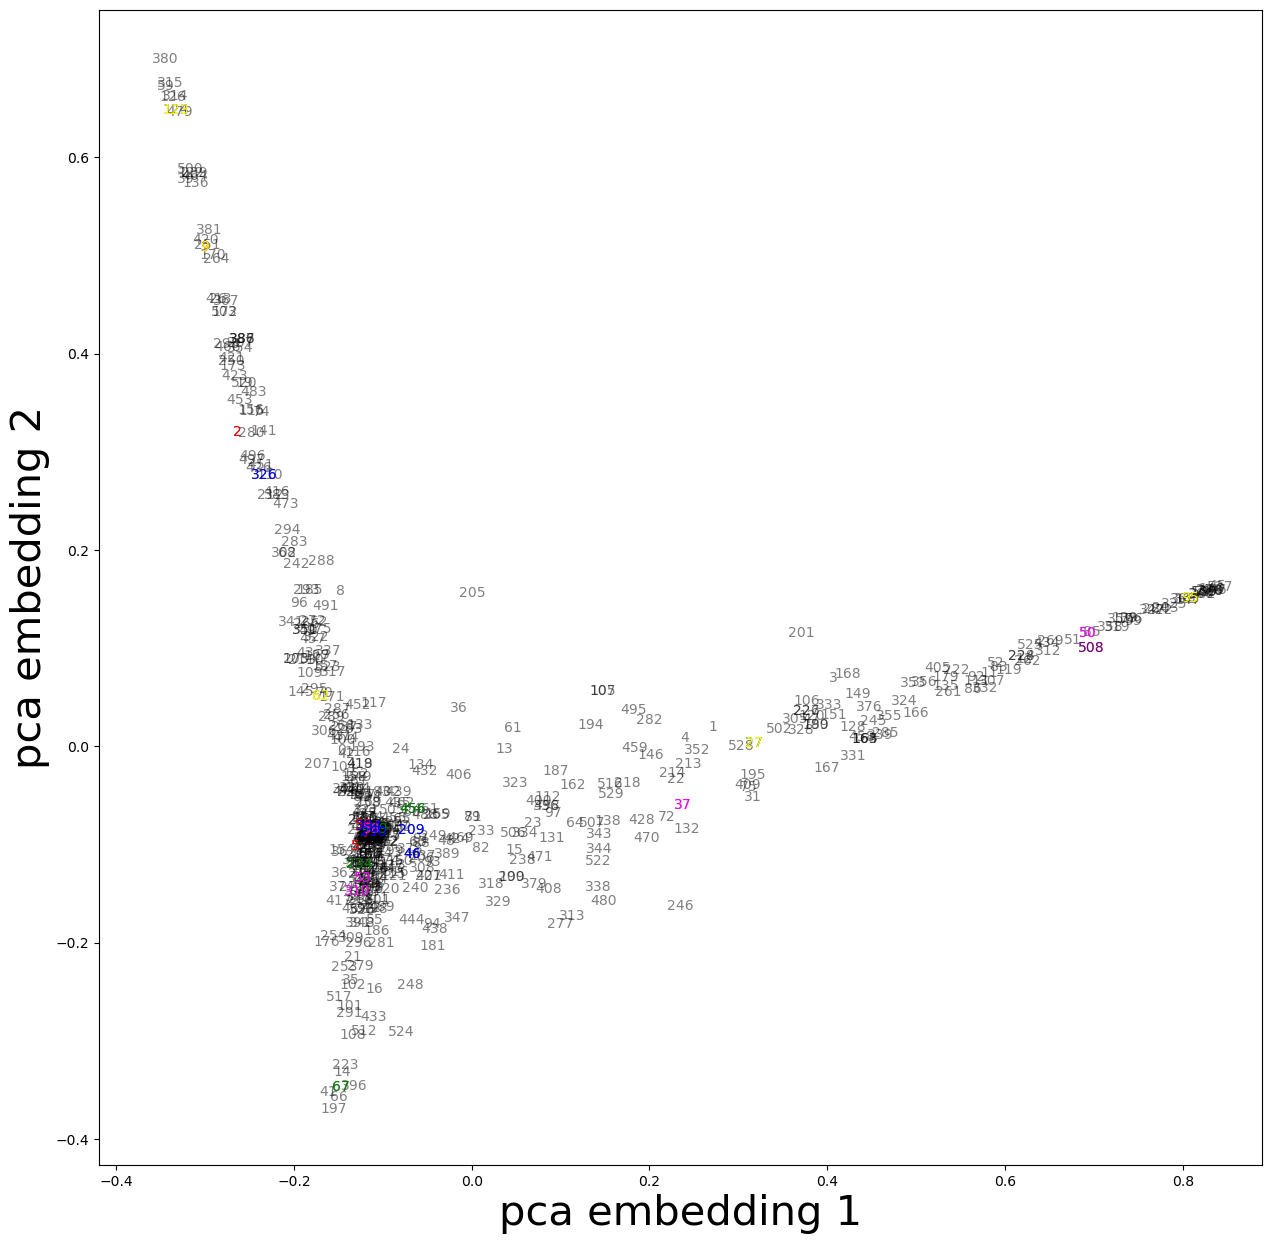

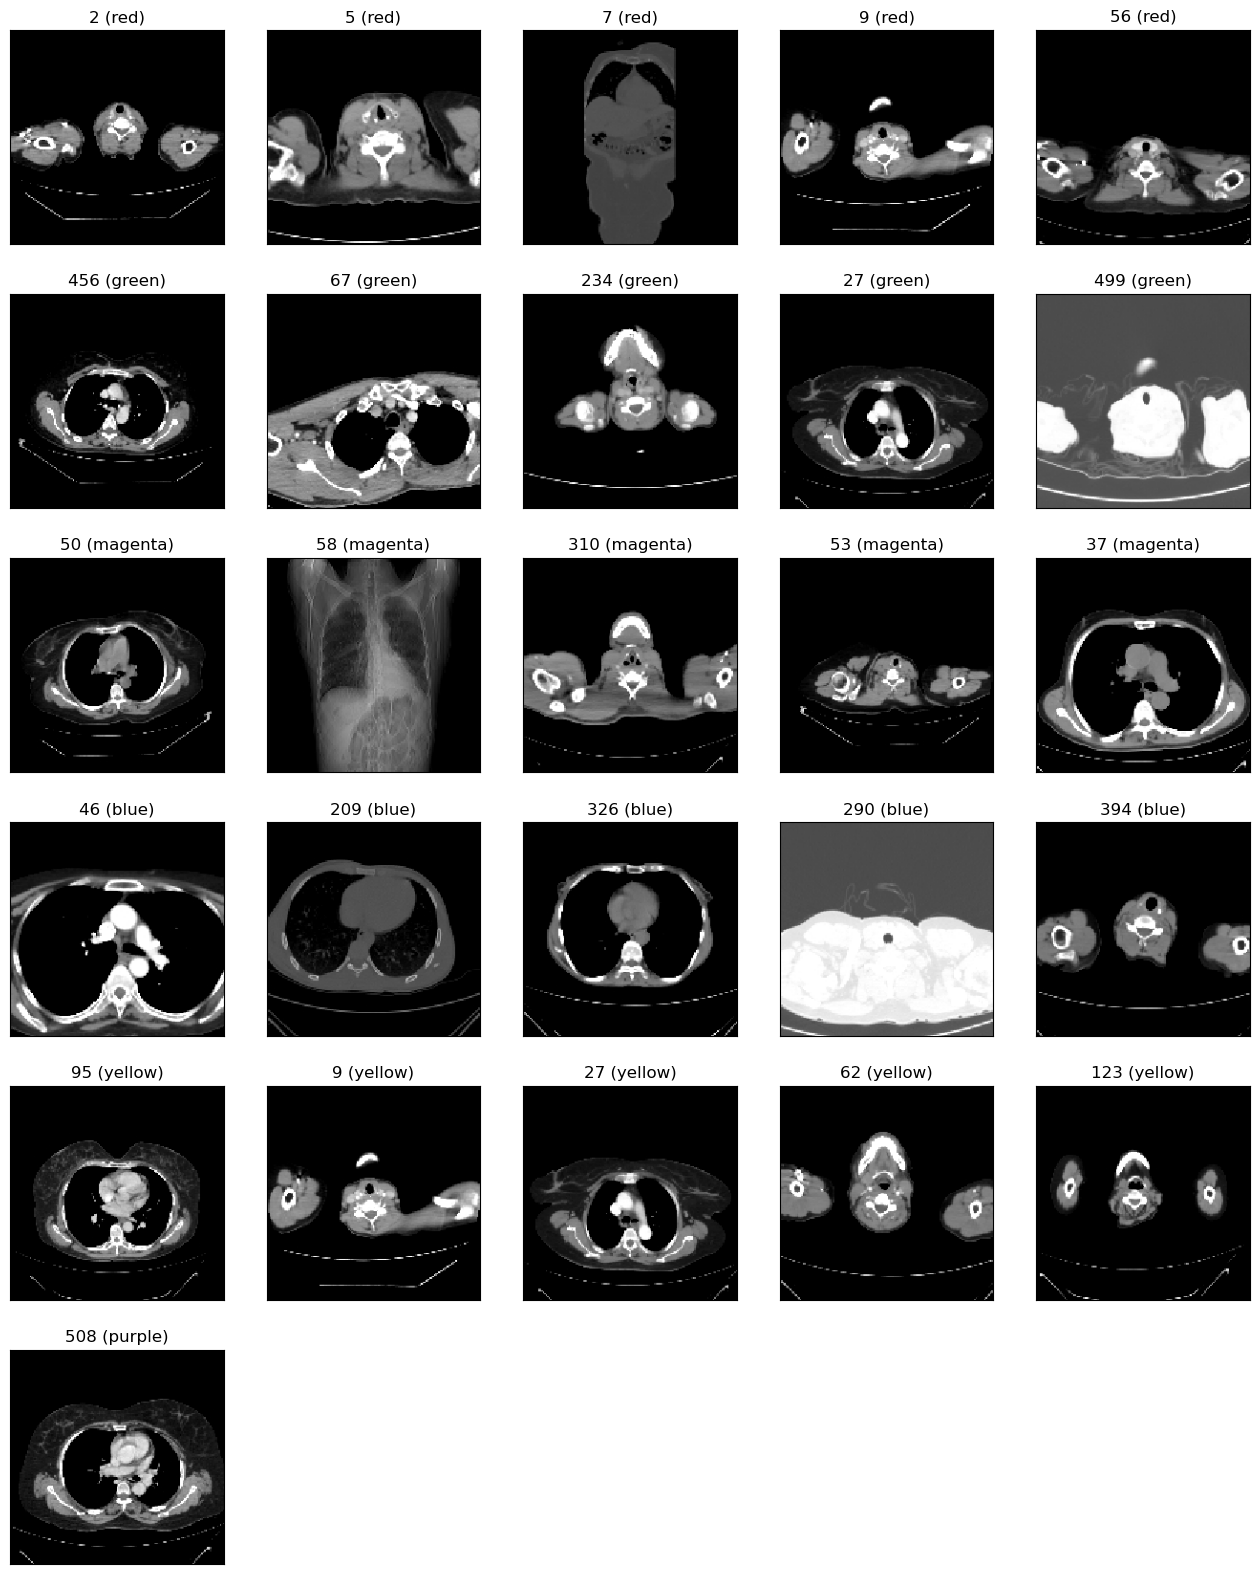

In [17]:
## some selected pictures that are creating clusters
picked_pic = OrderedDict()
picked_pic["red"]     = [2,5,7,9,56]
picked_pic["green"]   = [456,67,234,27, 499]
picked_pic["magenta"] = [50,58,310,53, 37]
picked_pic["blue"]    = [46,209,326,290,394]
picked_pic["yellow"]  = [95,9,27,62,123]
picked_pic["purple"]  = [508]

fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(y_pca[:,0],y_pca[:,1],c="white")

for irow in range(y_pca.shape[0]):
    ax.annotate(irow,y_pca[irow,:],color="black",alpha=0.5)
for color, irows in picked_pic.items():
    for irow in irows:
        ax.annotate(irow,y_pca[irow,:],color=color)
ax.set_xlabel("pca embedding 1",fontsize=30)
ax.set_ylabel("pca embedding 2",fontsize=30)
plt.show()


## plot of images
fig = plt.figure(figsize=(16,20))
count = 1
for color, irows in picked_pic.items():
    for ivec in irows:
        name = jpgs[ivec]
        filename = image_dir + '/' + name
        image = load_img(filename, target_size=target_size)

        ax = fig.add_subplot(len(picked_pic),5,count,
                         xticks=[],yticks=[])
        count += 1
        plt.imshow(image)
        plt.title("{} ({})".format(ivec,color))
plt.show()

## **Link the text and image data**

In this dataset, a single image has 2-10 captions. I will only use one caption out of 5 for simplicity.

Each row of the dtexts and dimages contain the same info. Remove captions (or images) that do not have corresponding images (or captions).

In [18]:
dimages, keepindex = [], []

# Iterate through all rows
for i, row in df_txt0.iterrows():
    fnm = row["image_id"]
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)

# Extract final data
fnames = df_txt0["image_id"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)


In [19]:
df_txt0.head()

image_id  caption_id                                            caption
0  100522.jpg           0  startseq There is right large heterogeneously ...
1  100522.jpg           1  startseq There is right superior sulcus mass l...
2  100522.jpg           2  startseq There is middle lobe bronchiectasis a...
3  100522.jpg           3  startseq Conclusion Spinal canal narrowing as ...
4  100522.jpg           4  startseq Conclusion Known cervical ca with mul...

**Tokenizer**

Change character vector to integer vector using Tokenizer

In [20]:
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
nb_words = 5175
tokenizer = Tokenizer(nb_words=nb_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 2878
[[3, 8, 5, 14, 165, 183, 37, 17, 150, 1, 844, 2, 54, 461, 11, 1, 42, 2, 445, 1634, 30, 8, 5, 7, 99, 81, 147, 446, 1, 16, 2, 14, 534, 845, 14, 398, 38, 280, 14, 955, 1258, 2, 49, 2, 207, 1078, 1079, 4], [3, 8, 5, 14, 207, 1259, 16, 17, 9, 175, 19, 225, 2, 2, 137, 153, 17, 150, 1, 82, 235, 11, 1, 131, 462, 956, 763, 2, 846, 623, 564, 16, 508, 65, 1, 494, 343, 2, 598, 509, 11, 1, 344, 4], [3, 8, 5, 180, 33, 447, 2, 19, 31, 9, 425, 411, 357, 4], [3, 74, 494, 343, 426, 84, 345, 217, 494, 336, 158, 4], [3, 74, 57, 79, 116, 9, 32, 28, 281, 42, 2, 140, 94, 4]]


**Split between training and testing data¶**

In [21]:
prop_test, prop_val = 0.2, 0.2

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest],
           dtexts[Ntest:Ntest+Nval],
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

The maximume length of captions

In [22]:
maxlen = np.max([len(text) for text in dtexts])

The final preprocessing so that the data can be used as input and output of the Keras model.

In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)
# pre-processing is not necessary for testing data
#Xtext_test,  Ximage_test,  ytext_test  = preprocessing(dt_test,di_test)

# captions/images = 1516
 (37125, 145) (37125, 1000) (37125, 2878)
# captions/images = 504
 (11981, 145) (11981, 1000) (11981, 2878)


**Model¶**

This model takes two inputs:

- 4096-dimensional image features from pre-trained VGG model
- tokenized captions up to tth word.

The single output is:
- tokenized t+1th word of caption

**Prediction¶**

Given the caption prediction up to the t
th word, the model can predict the t+1
st word in the caption, and then the input caption can be augmented with the predicted word to contain the caption up to the t+1
th word. The augmented caption up to the t+1
st word can, in turn, be used as input to predict the t+2
nd word in caption. The process is repeated until the "endseq" is predicted.

**A bit more detail:**

[Image] 4096-dimensional image features from pre-trained VGG model
The image feature is passed to fully connected layer with 256 hidden units.
[Caption up to t
] tokenized captions up to tth word.

The tokenized caption up to t
th time point is passed to embedding layer where each word is represented with a "dim_embedding" dimensional vector. This means that a single caption is represented as many time series of length "max_len".
The time series are passed to LSTM with 256 hidden states, and then a single output at the final time point is passed to the higher layer.
The networks are merged by simply adding the two vectors of size 256.

The vector of length 256 is passed to two dense layers and the final dense layer return probability that the t+1
st word is k
th word in the vocabulary (k=1,...,4476
).

In [24]:
from keras import layers, models

dim_embedding = 64
input_image = layers.Input(shape=(Ximage_train.shape[0],))  # Adjust shape as necessary
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)

# Sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature")(ftxt)

# Combined model for decoder
decoder = layers.add([ftxt, fimage])
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt], outputs=output)

model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 145)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 145, 64)   │    184,192 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 145)       │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 37125)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CaptionFeature      │ (None, 256)       │    328,704 │ embedding[0][0],  │
│ (LSTM)              │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageFeature        │ (None, 256)       │  9,504,256 │ input_layer_1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ CaptionFeature[0… │
│                     │                   │            │ ImageFeature[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2878)      │    739,646 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,822,590 (41.28 MB)

 Trainable params: 10,822,590 (41.28 MB)

 Non-trainable params: 0 (0.00 B)

None


## Fix the Model to Accept Image Features of Shape (None, 1000)
#**Buiding the LSTM model**

Since your image features have already been reduced to 1000 dimensions (likely through a feature extractor or preprocessing pipeline), the simplest fix is to modify the model to accommodate this input shape.

Here’s how to adjust the model architecture:

In [25]:
from keras import layers, models

dim_embedding = 64

# Input for image features (adjusted to 1000)
input_image = layers.Input(shape=(1000,), name="ImageFeature")
fimage = layers.Dense(256, activation='relu', name="ImageDense")(input_image)

# Input for text sequences
input_txt = layers.Input(shape=(145,), name="InputText")
ftxt = layers.Embedding(vocab_size, dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature")(ftxt)

# Combine both inputs for decoding
decoder = layers.add([ftxt, fimage], name="AddFeatures")
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)

model = models.Model(inputs=[input_image, input_txt], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Display the updated model architecture
print(model.summary())


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ InputText           │ (None, 145)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 145, 64)   │    184,192 │ InputText[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 145)       │          0 │ InputText[0][0]   │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageFeature        │ (None, 1000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CaptionFeature      │ (None, 256)       │    328,704 │ embedding_1[0][0… │
│ (LSTM)              │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ImageDense (Dense)  │ (None, 256)       │    256,256 │ ImageFeature[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AddFeatures (Add)   │ (None, 256)       │          0 │ CaptionFeature[0… │
│                     │                   │            │ ImageDense[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ AddFeatures[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2878)      │    739,646 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,574,590 (6.01 MB)

 Trainable params: 1,574,590 (6.01 MB)

 Non-trainable params: 0 (0.00 B)

None


## **Model training**

In [26]:
print("Ximage_train shape:", Ximage_train.shape)
print("Xtext_train shape:", Xtext_train.shape)
print("ytext_train shape:", ytext_train.shape)


Ximage_train shape: (37125, 1000)
Xtext_train shape: (37125, 145)
ytext_train shape: (37125, 2878)


In [27]:
# fit model
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train,
                  epochs=5, verbose=2,
                  batch_size=32,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Epoch 1/5
1161/1161 - 408s - 352ms/step - loss: 5.4175 - val_loss: 4.6355
Epoch 2/5
1161/1161 - 420s - 362ms/step - loss: 4.0351 - val_loss: 3.8567
Epoch 3/5
1161/1161 - 426s - 367ms/step - loss: 3.3340 - val_loss: 3.5861
Epoch 4/5
1161/1161 - 415s - 358ms/step - loss: 2.9396 - val_loss: 3.5230
Epoch 5/5
1161/1161 - 413s - 356ms/step - loss: 2.6556 - val_loss: 3.5753
TIME TOOK 35.52MIN


In [28]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(37125, 1000) (37125, 145) (37125, 2878)


**Validation loss and training loss over epochs**

The model over fit very quickly. This makes sense considering the small size of our data.

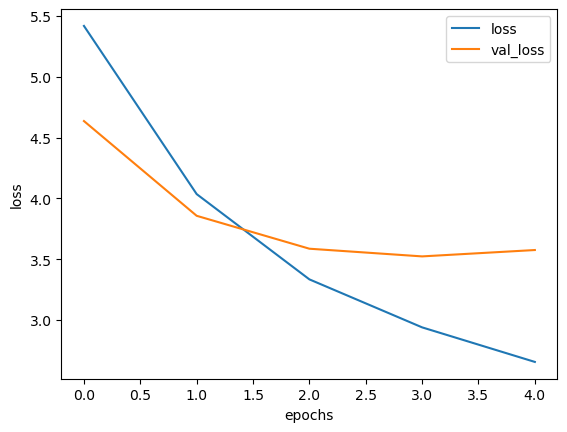

In [29]:
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


**Prediction**

Prediction of testing image makes sense! **only on caption for given image** 

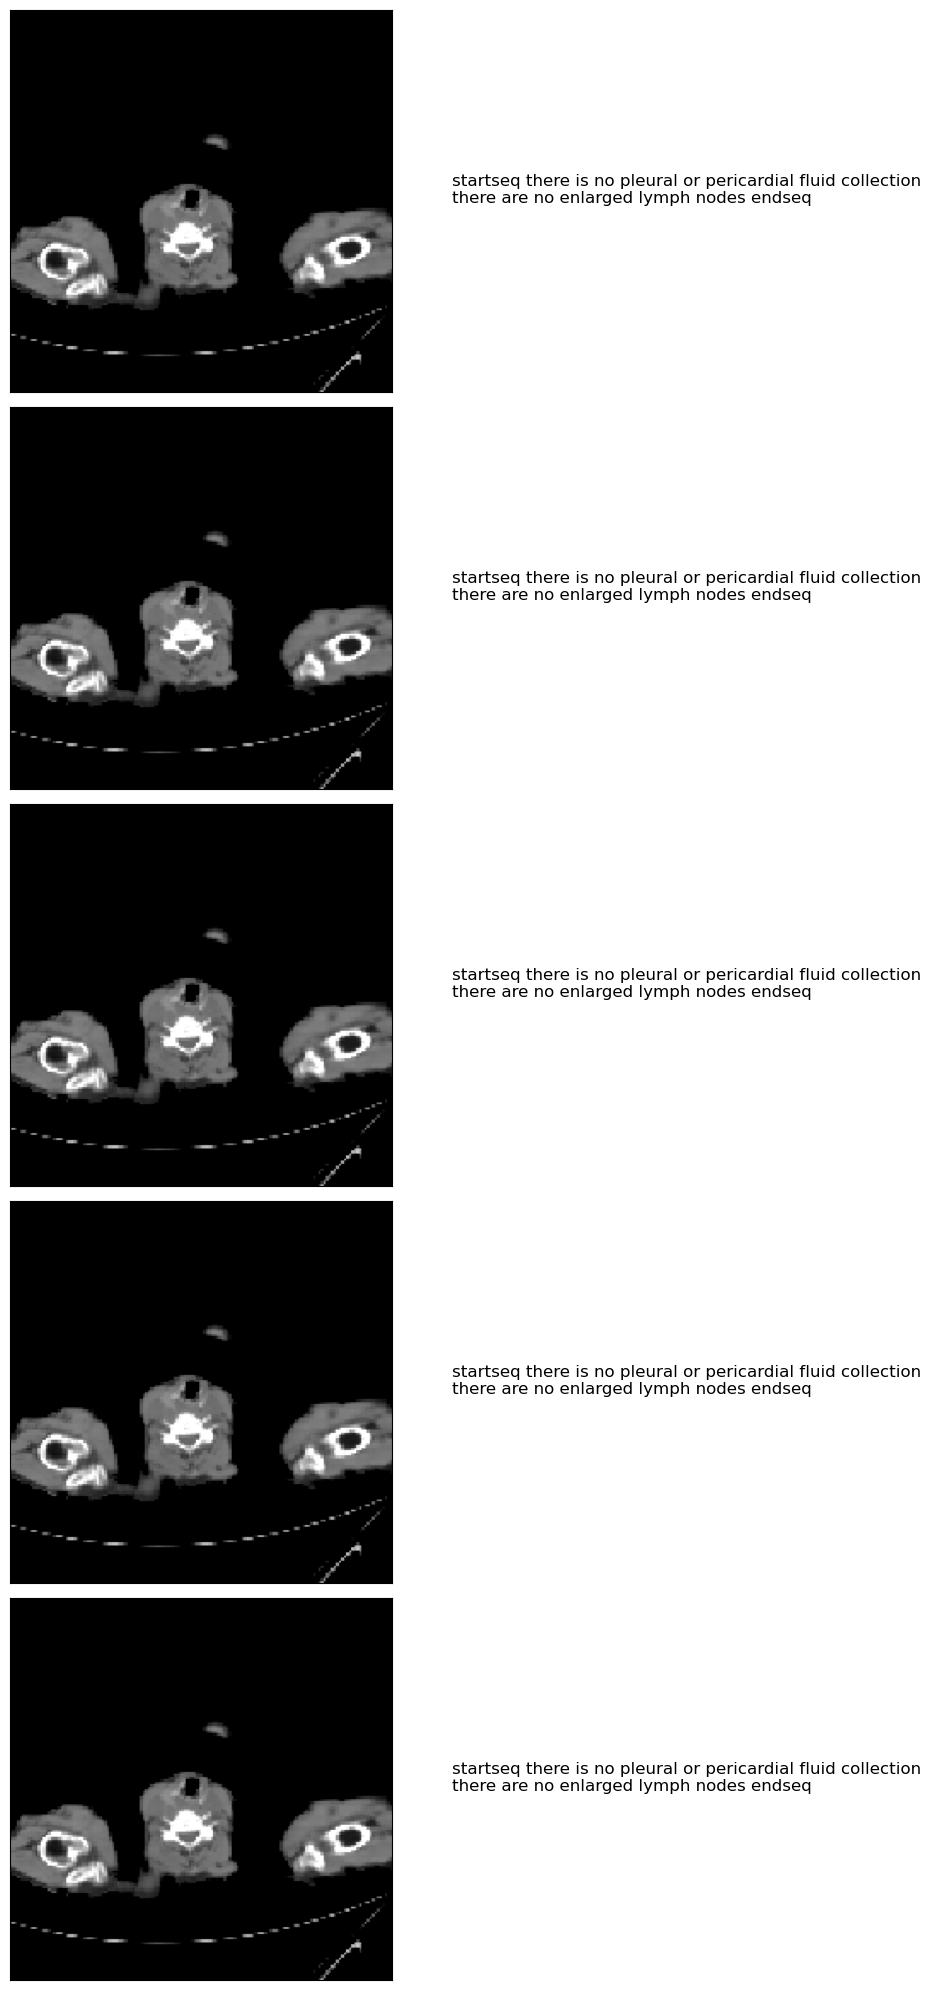

In [30]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'

    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5  # Number of images to display
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10, 20))

# Iterate through unique image-feature pairs
for idx in range(npic):
    jpgfnm = fnm_test[idx]         # Get the image filename
    image_feature = di_test[idx]  # Get the corresponding feature

    ## Load and display the image
    filename = image_dir + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ## Generate and display the caption
    caption = predict_caption(image_feature.reshape(1, len(image_feature)))
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.text(0.1, 0.5, caption, fontsize=12, wrap=True)
    count += 1

plt.tight_layout()
plt.show()

## Visualization Code for Multiple Captions
### Prediction of testing image makes sense! **multipl on caption for given image** 
- We introduce randomness by sampling multiple outputs from the model's predicted probability distribution:
- For each image, we display multiple captions under it.

In [31]:
def predict_multiple_captions(image, num_captions=3):
    """
    Generate multiple captions for a given image feature using the model.
    
    Args:
        image: The image feature array (1, num_features).
        num_captions: Number of captions to generate for the image.
    
    Returns:
        A list of generated captions.
    """
    captions = []

    for _ in range(num_captions):
        in_text = 'startseq'
        for iword in range(maxlen):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen)
            yhat = model.predict([image, sequence], verbose=0)
            
            # Use randomness to sample a word from the distribution
            yhat = np.random.choice(len(yhat[0]), p=yhat[0])
            newword = index_word[yhat]
            
            in_text += " " + newword
            if newword == "endseq":
                break
        captions.append(in_text)
    
    return captions

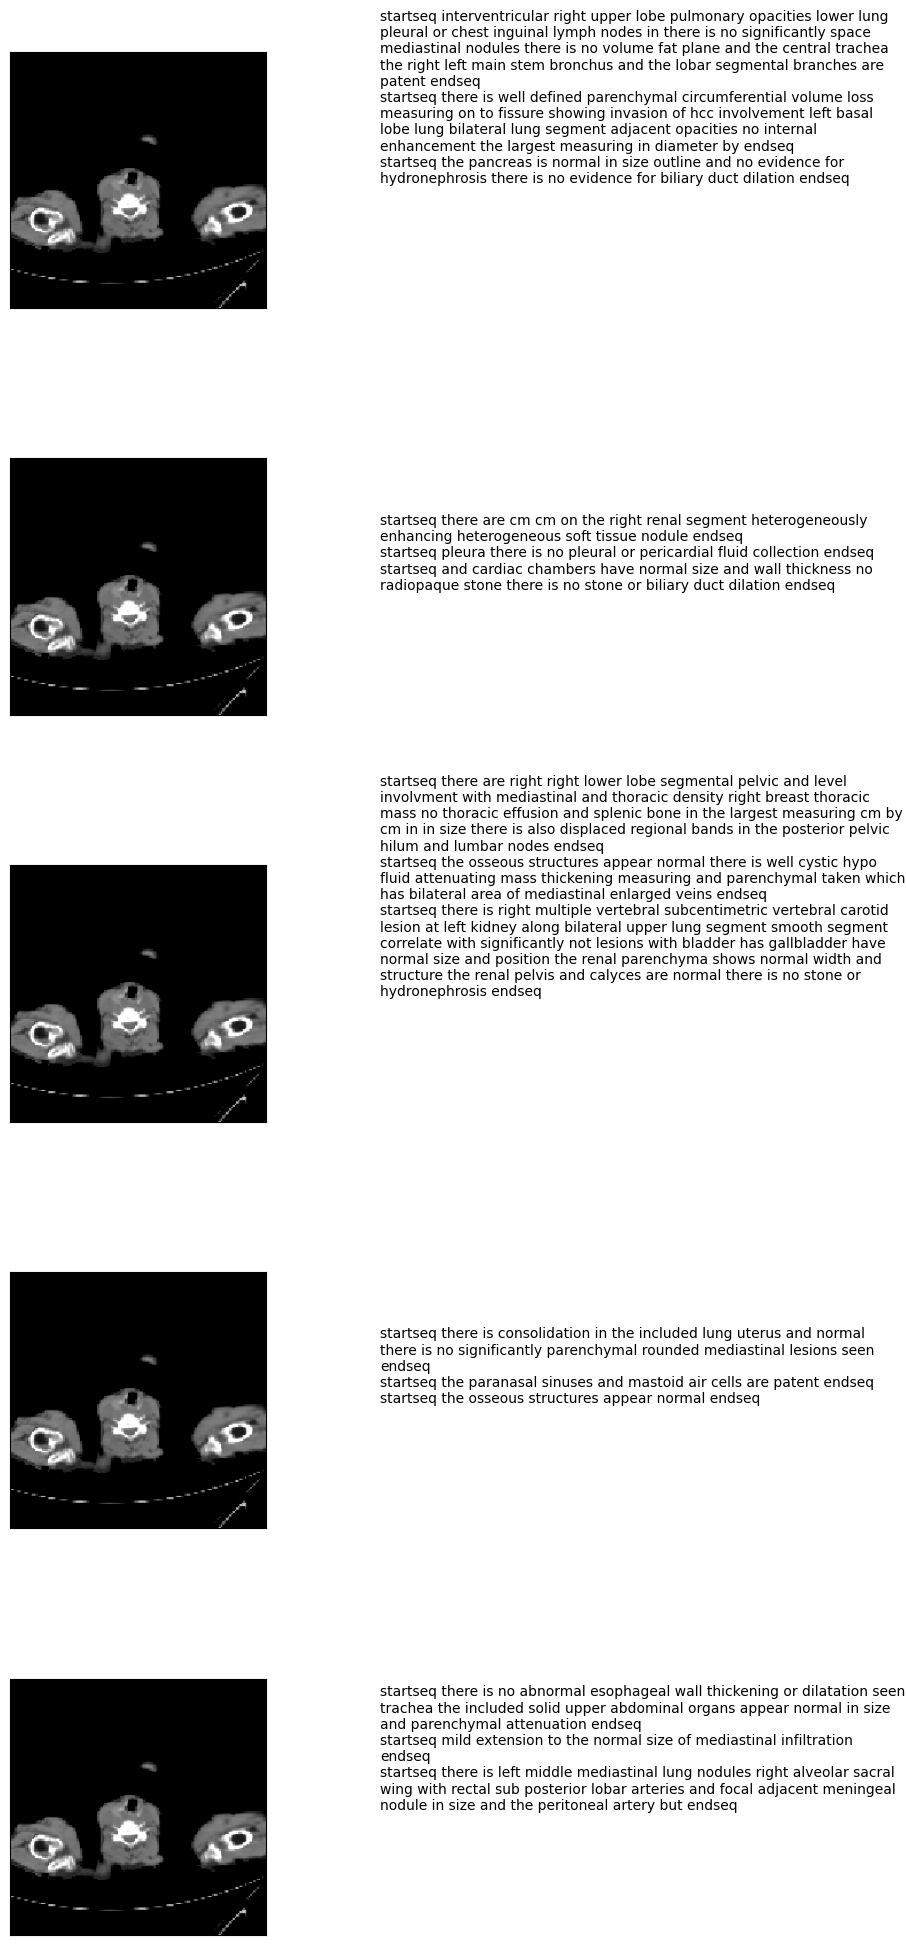

In [32]:
npic = 5  # Number of images to display
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(10, 20))

for idx in range(npic):
    # Load image filename and corresponding feature
    jpgfnm = fnm_test[idx]
    image_feature = di_test[idx]

    # Load and display the image
    filename = image_dir + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    # Generate all available captions for this image
    captions = predict_multiple_captions(image_feature.reshape(1, len(image_feature)))
    
    # Display all captions for this image
    ax = fig.add_subplot(npic, 2, count)
    plt.axis('off')
    ax.text(0.1, 0.5, "\n".join(captions), fontsize=10, wrap=True)
    count += 1

plt.tight_layout()
plt.show()


**Bilingual evaluation understudy (BLEU)**

I want to evaluate the model performance in the prediction. Is there any good metric?

BLEU is a well-acknowledged metric to measure the similarly of one hypothesis sentence to multiple reference sentences. Given a single hypothesis sentence and multiple reference sentences, it returns value between 0 and 1. The metric close to 1 means that the two are very similar. The metric was introduced in 2002 BLEU: a Method for Automatic Evaluation of Machine Translation. Although there are many problems in this metric, for example grammatical correctness are not taken into account, BLEU is very well accepted partly because it is easy to calculate.

**Basic idea of BLEU**

The authors of the paper say that:

The primary programming task for a BLEU implementor is to compare n-grams of the candidate with the n-grams of the reference translation and count the number of matches. These matches are position-independent. The more the matches, the better the candidate translation is.

For example let's consider the scenario where I want to compare the similarly between the hypothesis sentence and the reference sentence. The hypothesis sentence is

I like dogs

and the reference sentence is:

I do like dogs

From the hypothesis sentence, I can create 2 2-grams:

(I, like)
(like, dogs)

From the reference sentence, I can create 3 2-grams:

(I, do)
(do, like)
(like, dogs)
Which 2-gram from hypothesis exists in reference? The reference sentence has (like, dog) that is one of the 2-gram from hypothesis. This means that out of the two 2-grams from hypothesis, 1 exists in the reference i.e., 50% of 2-gram from the hypothesis exists in reference. This 50% is what's called "modified precision".

This modified precision has the problem that when the number of words is larger than the hypothesis length, then the modified precision tends to be larger. For example, if the reference sentence contains 10000 words and its sub-sentence happened to contain "I do like dogs" sentence, this also gives the modified precision of 50%. However, the reference sentence and the hypothesis sentence should be considered less similar. To account for this, BLEU calculation penalizes the long reference sentence. The penalty is simply

exp(1−lengh of referencelength of hypothesis)
Modified precision is multiplied by this reference factor to yield 2-gram BLEU. In this particular example, the penalty is exp(1−4/3)=0.717
 so the 2-gram BLEU is 0.717*0.5 = 0.3585.

Finally, 1-gram BLEU, 2-gram BLEU, 3-gram BLEU and 4-gram BLEU are calculated and its average is reported as BLEU.

**Implementation**

BLEU score calculation is implemented in nltk.util and the source code is available. I found this source code is the easiest way to understand this metric. So I will go over the script to understand how the calculation works.

Let's introduce one hypothesis string and one reference string, and see how similar they are according to BLEU.

In [33]:
hypothesis = "I like dog"
hypothesis = hypothesis.split()
reference  = "I do like dog"
references = [reference.split()] ## references must be a list containing list.

According to BLEU the two sentences are reasonably similar.

In [34]:
from nltk.translate.bleu_score import sentence_bleu
print("BLEU={:4.3f}".format(sentence_bleu(references,hypothesis)))


BLEU=0.000


**2-gram BLEU calculation step by step¶**

The main calculation of BLEU is done in modified_precision(references, hypothesis, n). So Let's try to understand this method.

As the first step, given "n" of n-gram, compute n-gram and count the frequency of each n-gram.

In [35]:
from nltk.util import ngrams
n = 2
# Extracts all ngrams in hypothesis
# Set an empty Counter if hypothesis is empty.
counts = Counter(ngrams(hypothesis, n)) if len(hypothesis) >= n else Counter()
# Extract a union of references' counts.
counts

Counter({('I', 'like'): 1, ('like', 'dog'): 1})

max_counts is a dictionary containing the same key as counts; i.e. the n-gram from the hypothesis is a key. It records how many of the ngram from hypothesis exists in each of the reference sentences.

In [36]:
max_counts = {}
for reference in references:
    reference_counts = Counter(ngrams(reference, n)) if len(reference) >= n else Counter()
    for ngram in counts: ## ngram from hypothesis
        max_counts[ngram] = max(max_counts.get(ngram, 0),
                                reference_counts[ngram])

max_counts

{('I', 'like'): 0, ('like', 'dog'): 1}

Modified precision is:

In [37]:
# Assigns the intersection between hypothesis and references' counts.
clipped_counts = {ngram: min(count, max_counts[ngram])
                      for ngram, count in counts.items()}

numerator = sum(clipped_counts.values())
# Ensures that denominator is minimum 1 to avoid ZeroDivisionError.
# Usually this happens when the ngram order is > len(reference).
denominator = max(1, sum(counts.values()))

modified_precision = numerator/float(denominator)
print(modified_precision)

0.5


Compute the penalty:

In [38]:
ref_len = len(reference)
hyp_len = float(len(hypothesis))
brevity_penalty = np.exp(1 - ref_len / hyp_len)
print("reference length = {:1.0f}, hypothesis length = {:1.0f}, penalty = {:4.3f}".format(
    ref_len,hyp_len,brevity_penalty))

reference length = 4, hypothesis length = 3, penalty = 0.717


*2*-gram BLEU is:

In [39]:
brevity_penalty*modified_precision

0.35826565528689464

We can also calculate the 2-gram BLEU using the sentence_bleu function by setting only the second position in weight as 1.

In [40]:
print("2-gram result:{}".format(sentence_bleu(references,hypothesis, weights=[0,1,0,0])))

2-gram result:0.35826565528689464


**Back to image captioning problem**

Now we understand what BLEU does and we are ready to calculate the BLEU for our test set.

In [41]:
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], []
count = 0
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))

    caption_true = [ index_word[i] for i in tokenized_text ]
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg

    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  39.68% is done..
  79.37% is done..


**The mean BLEU value for testing data¶**

In [42]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.049


Plot the images with good captions (BLEU > 0.9) and bad captions (BLEU < 0.1)

Bad Caption


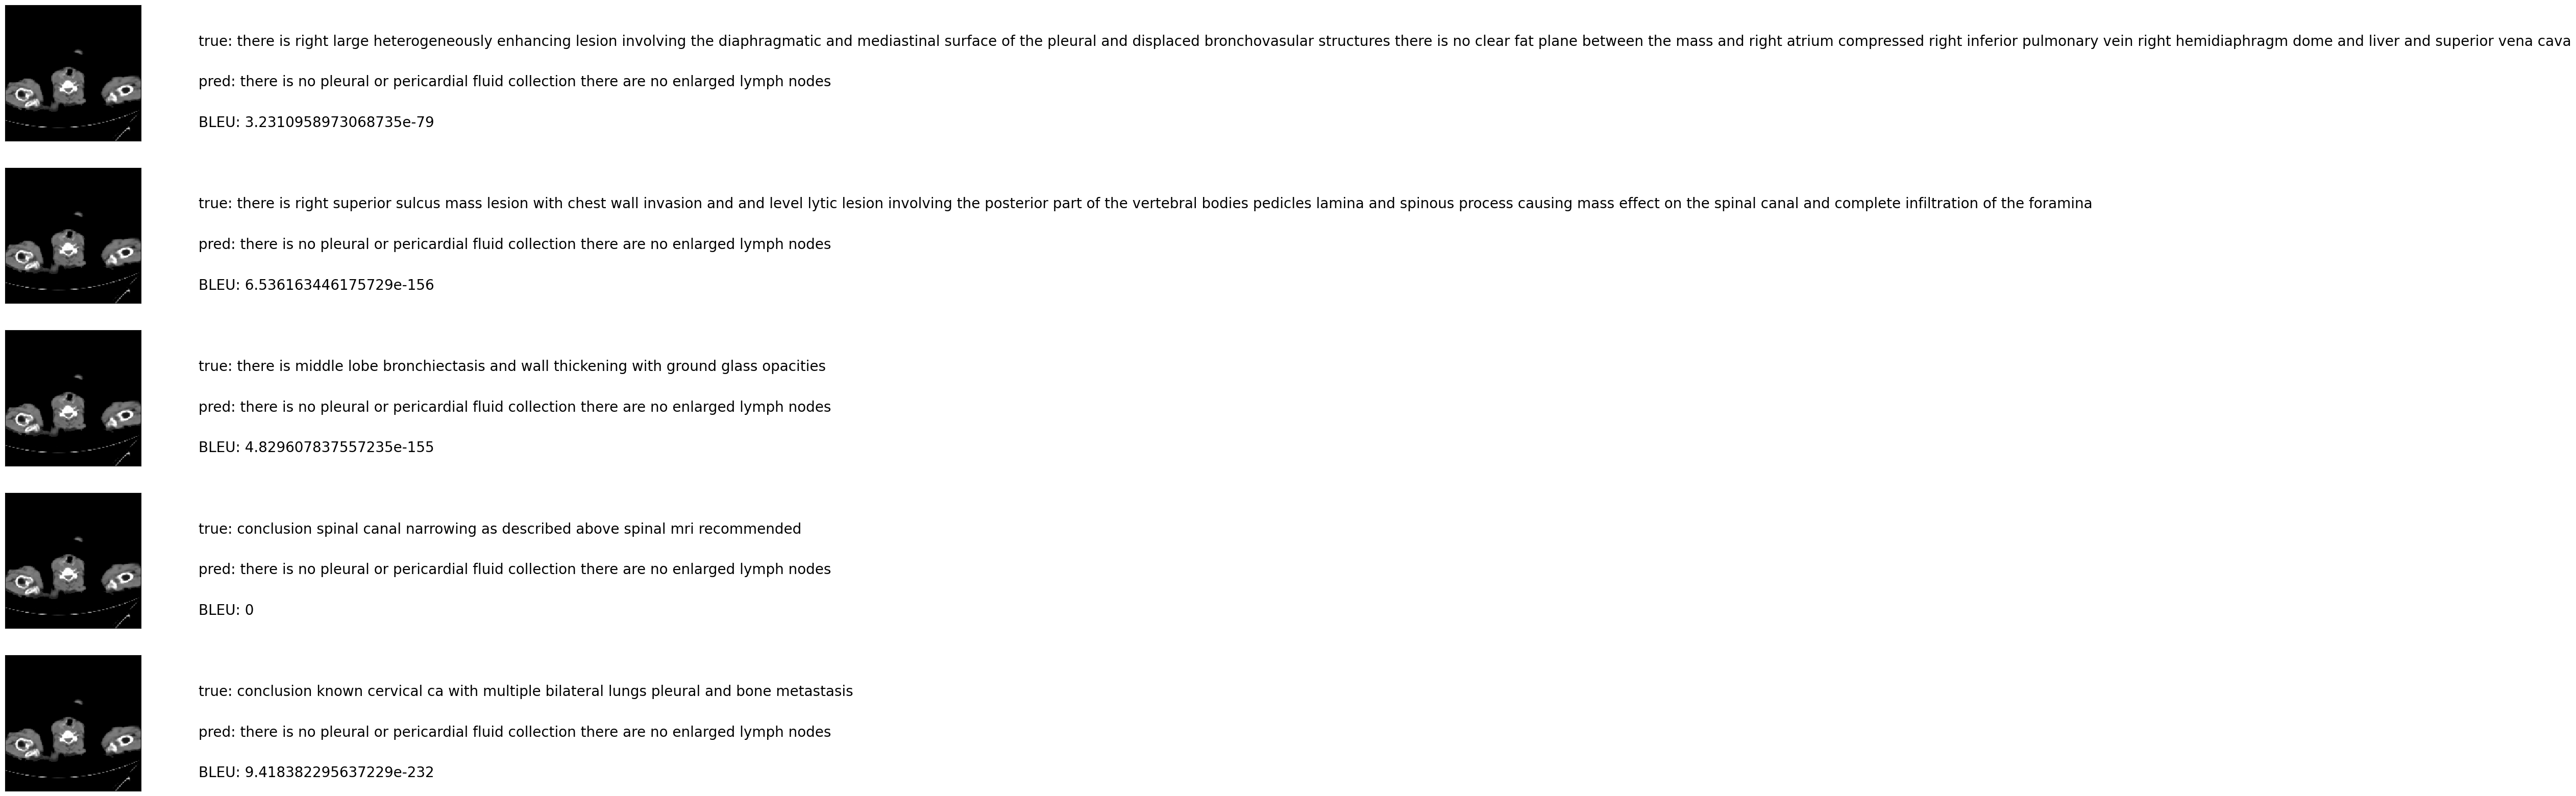

Good Caption


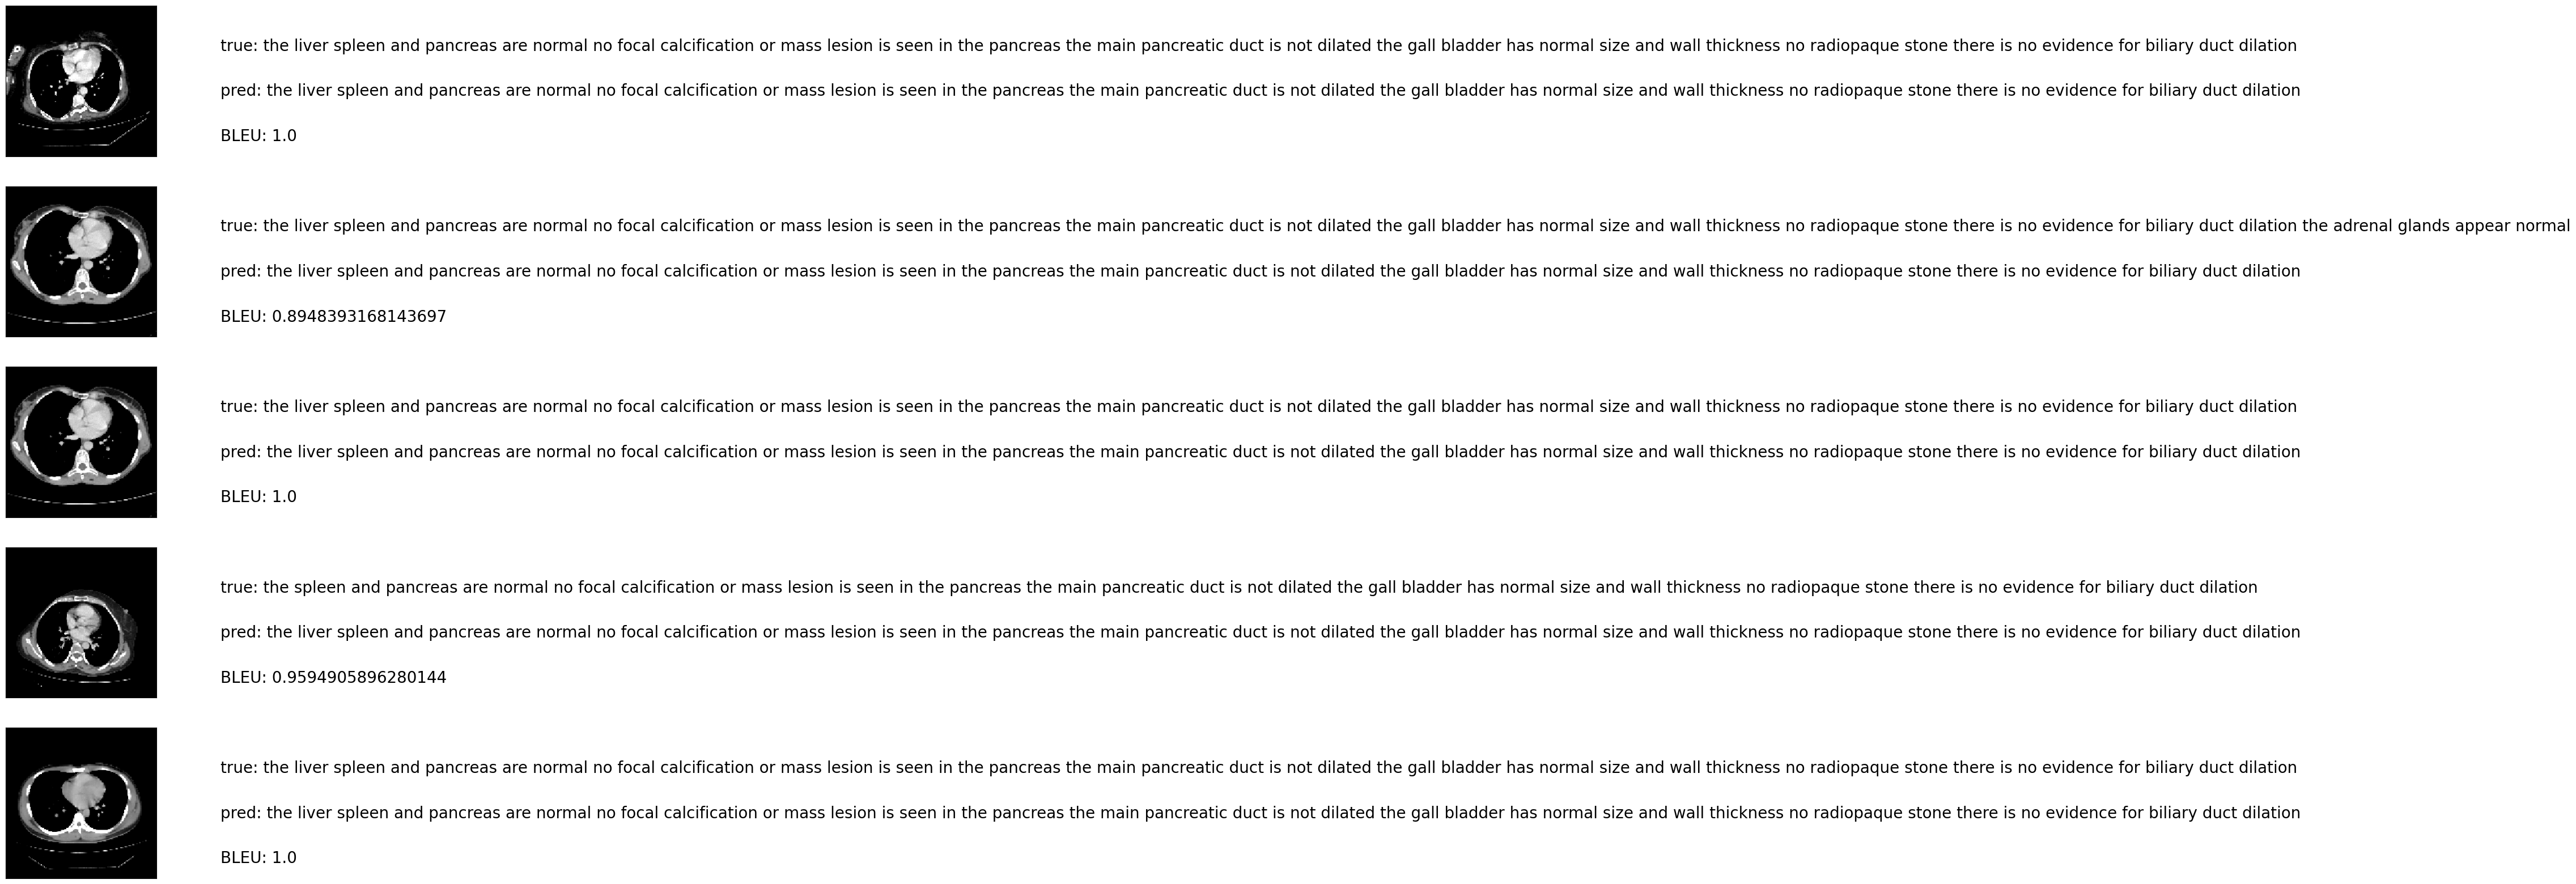

In [43]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images
        filename = image_dir + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)

        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)

## Multiple caption for given image 

Bad Captions


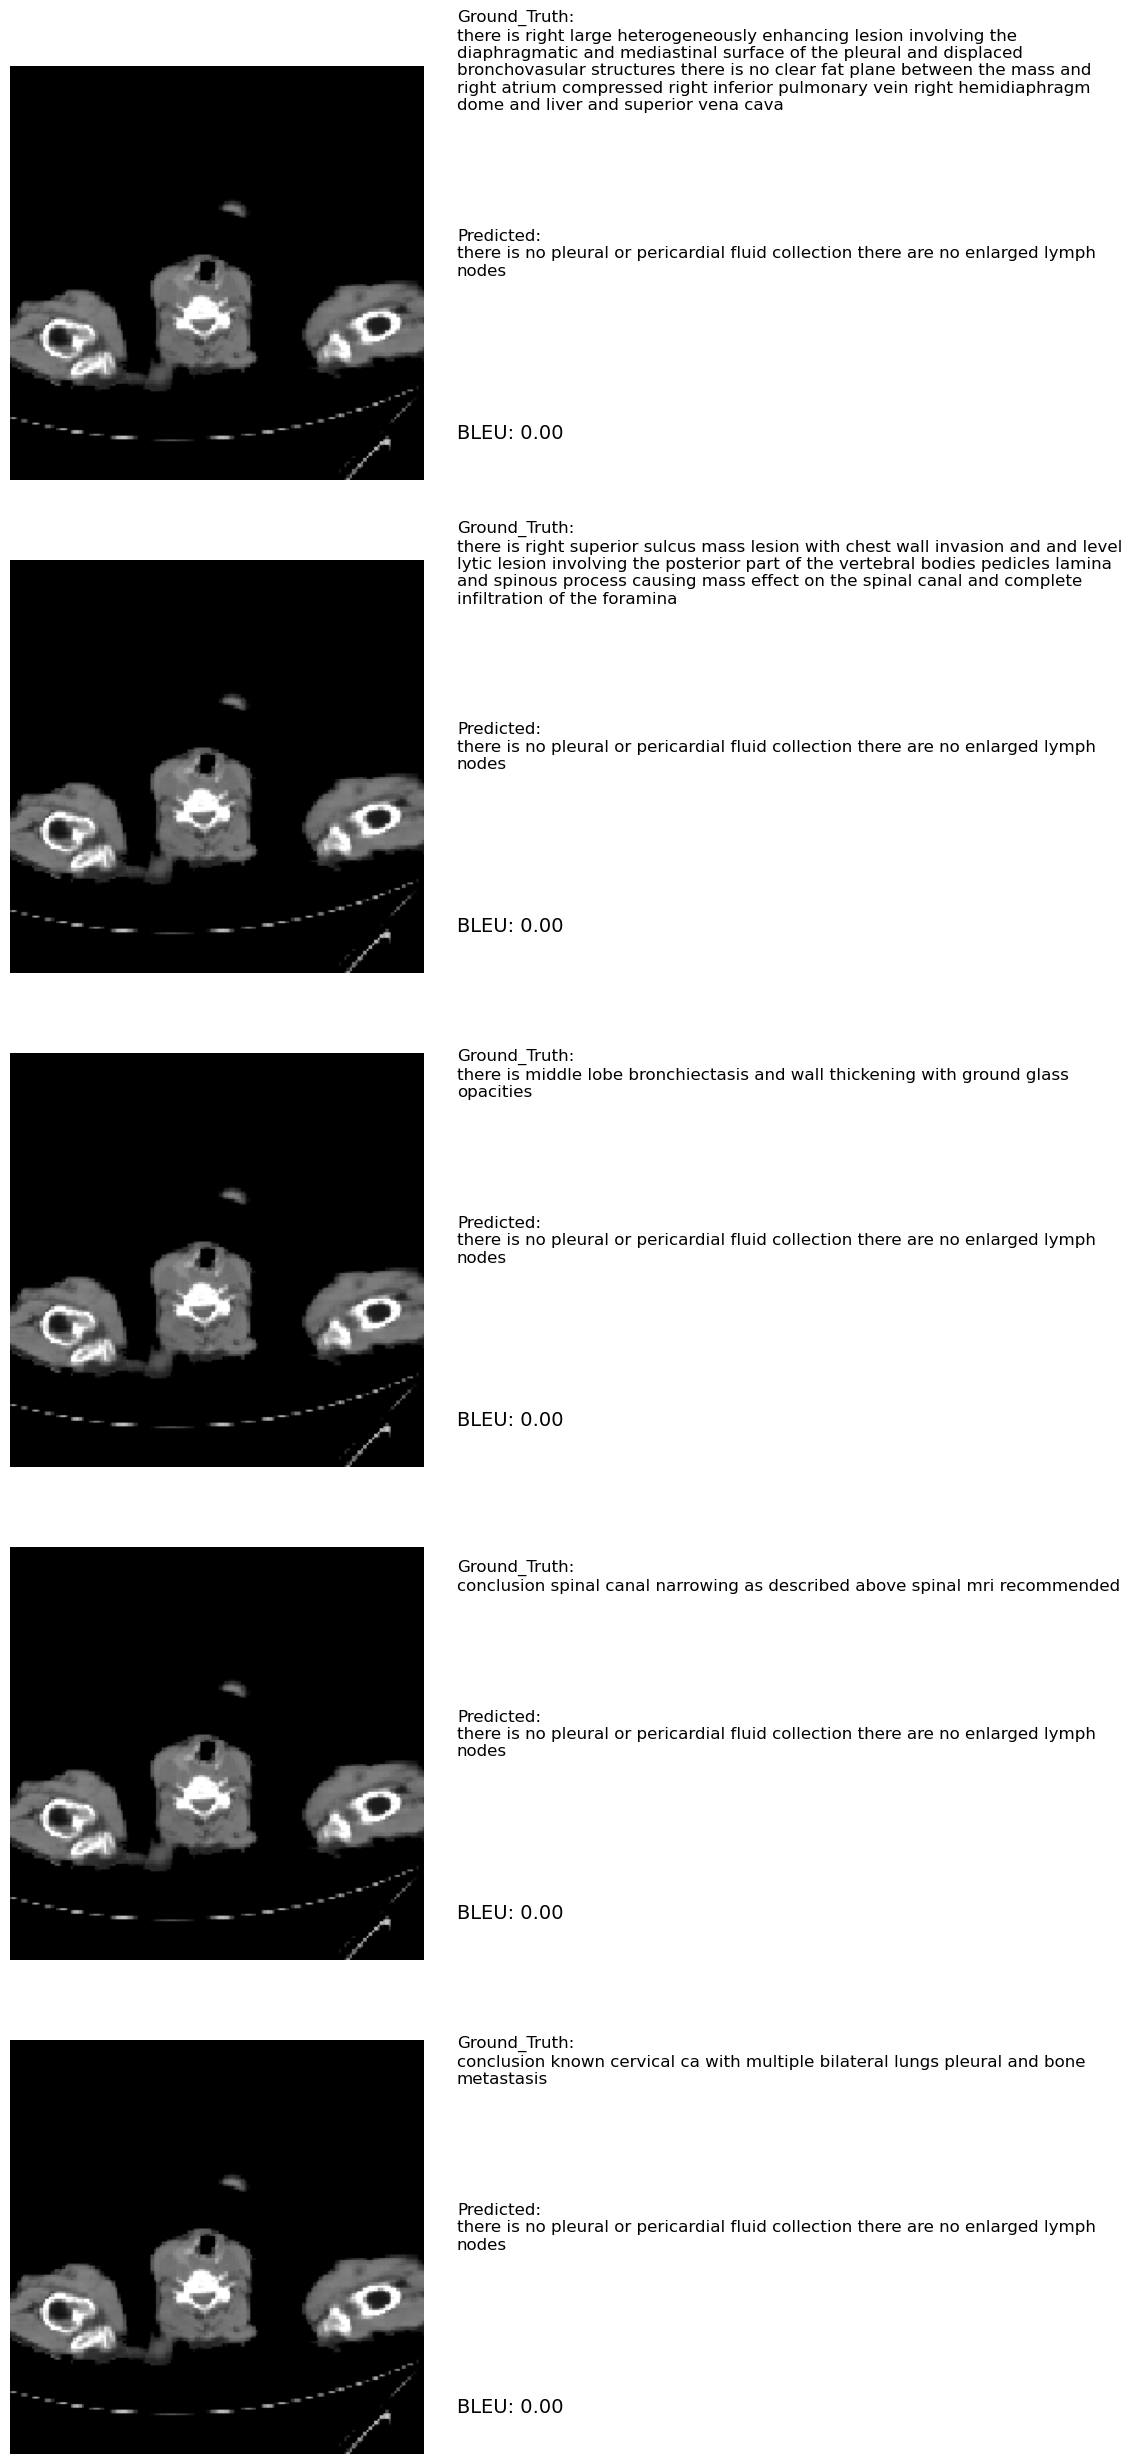

Good Captions


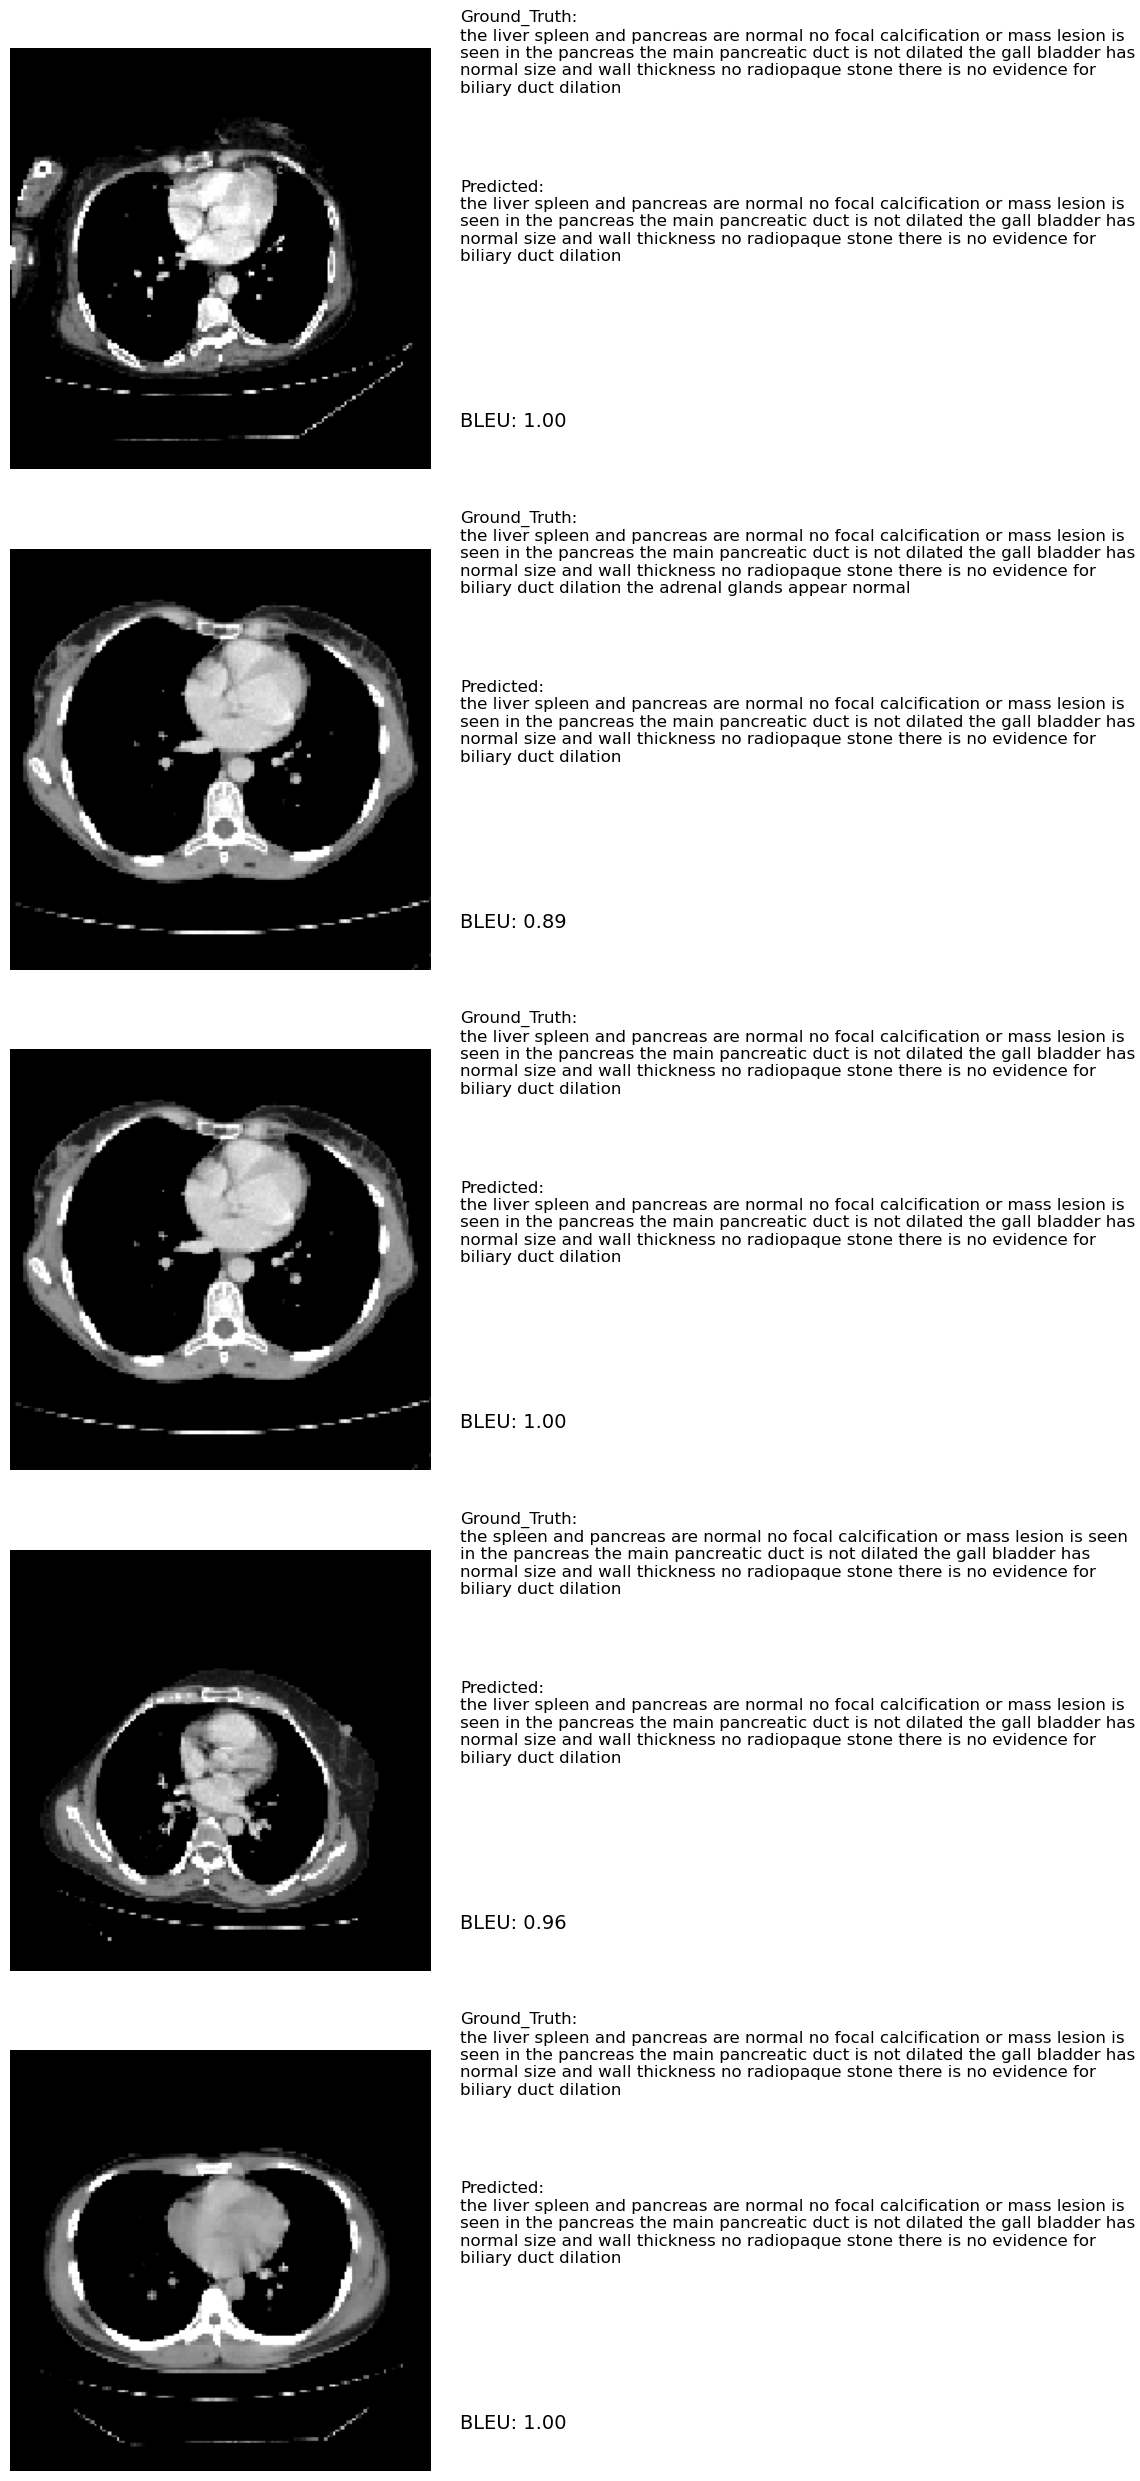

In [44]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

def plot_images(pred_bad):
    def create_paragraph(captions):
        """Creates a paragraph by joining captions."""
        return " ".join(captions)
    
    npix = 224
    target_size = (npix, npix, 3)
    count = 0
    npic = len(pred_bad)
    
    # Create a figure with 2 columns: Image and Captions (Ground Truth & Predicted)
    fig, axes = plt.subplots(npic, 2, figsize=(12, npic * 5))
    
    for pb in pred_bad:
        bleu, jpgfnm, caption_true, caption_pred = pb
        
        # Load image
        filename = image_dir + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        
        # Display image in the first column
        ax_img = axes[count, 0]
        ax_img.imshow(image_load)
        ax_img.axis('off')  # Hide axis
        
        # Create caption paragraphs
        caption_true_paragraph = create_paragraph(caption_true)
        caption_pred_paragraph = create_paragraph(caption_pred)

        # Add text for Ground_Truth and Predicted in the second column
        ax_text = axes[count, 1]
        ax_text.axis('off')  # Hide axis for the text area
        ax_text.set_xlim(0, 1)
        ax_text.set_ylim(0, 1)

        # Display text (Ground_Truth, Predicted, and BLEU Score)
        ax_text.text(0, 0.9, f"Ground_Truth:\n{caption_true_paragraph}", fontsize=12, wrap=True)
        ax_text.text(0, 0.5, f"Predicted:\n{caption_pred_paragraph}", fontsize=12, wrap=True)
        ax_text.text(0, 0.1, f"BLEU: {bleu:.2f}", fontsize=14)

        count += 1

    plt.tight_layout()
    plt.show()

# Display Bad Captions
print("Bad Captions")
plot_images(pred_bad)

# Display Good Captions
print("Good Captions")
plot_images(pred_good)


Bad Captions


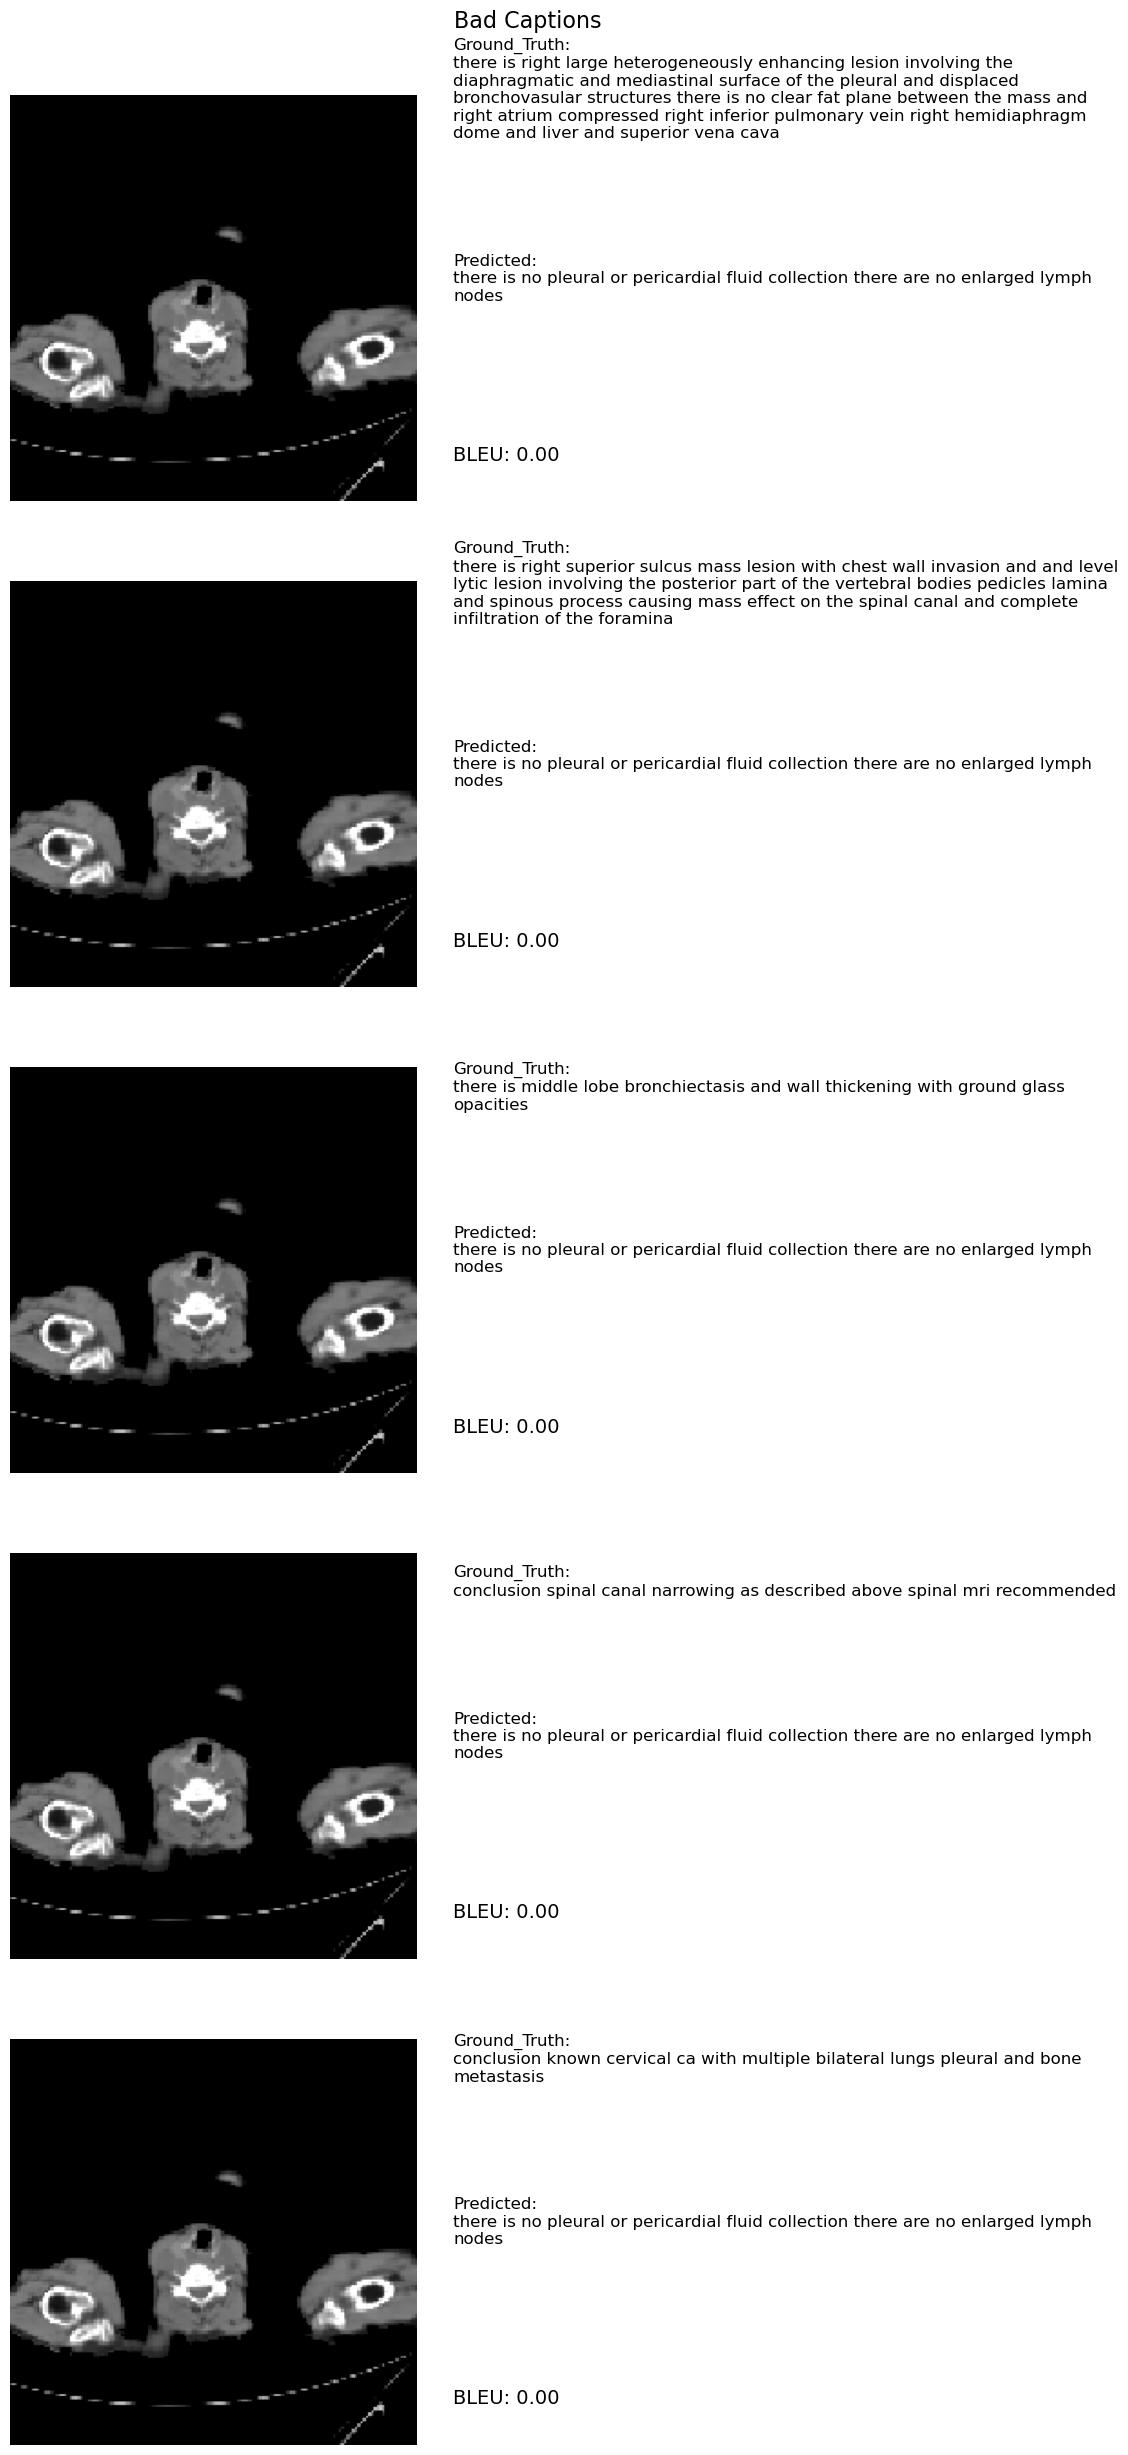

Good Captions


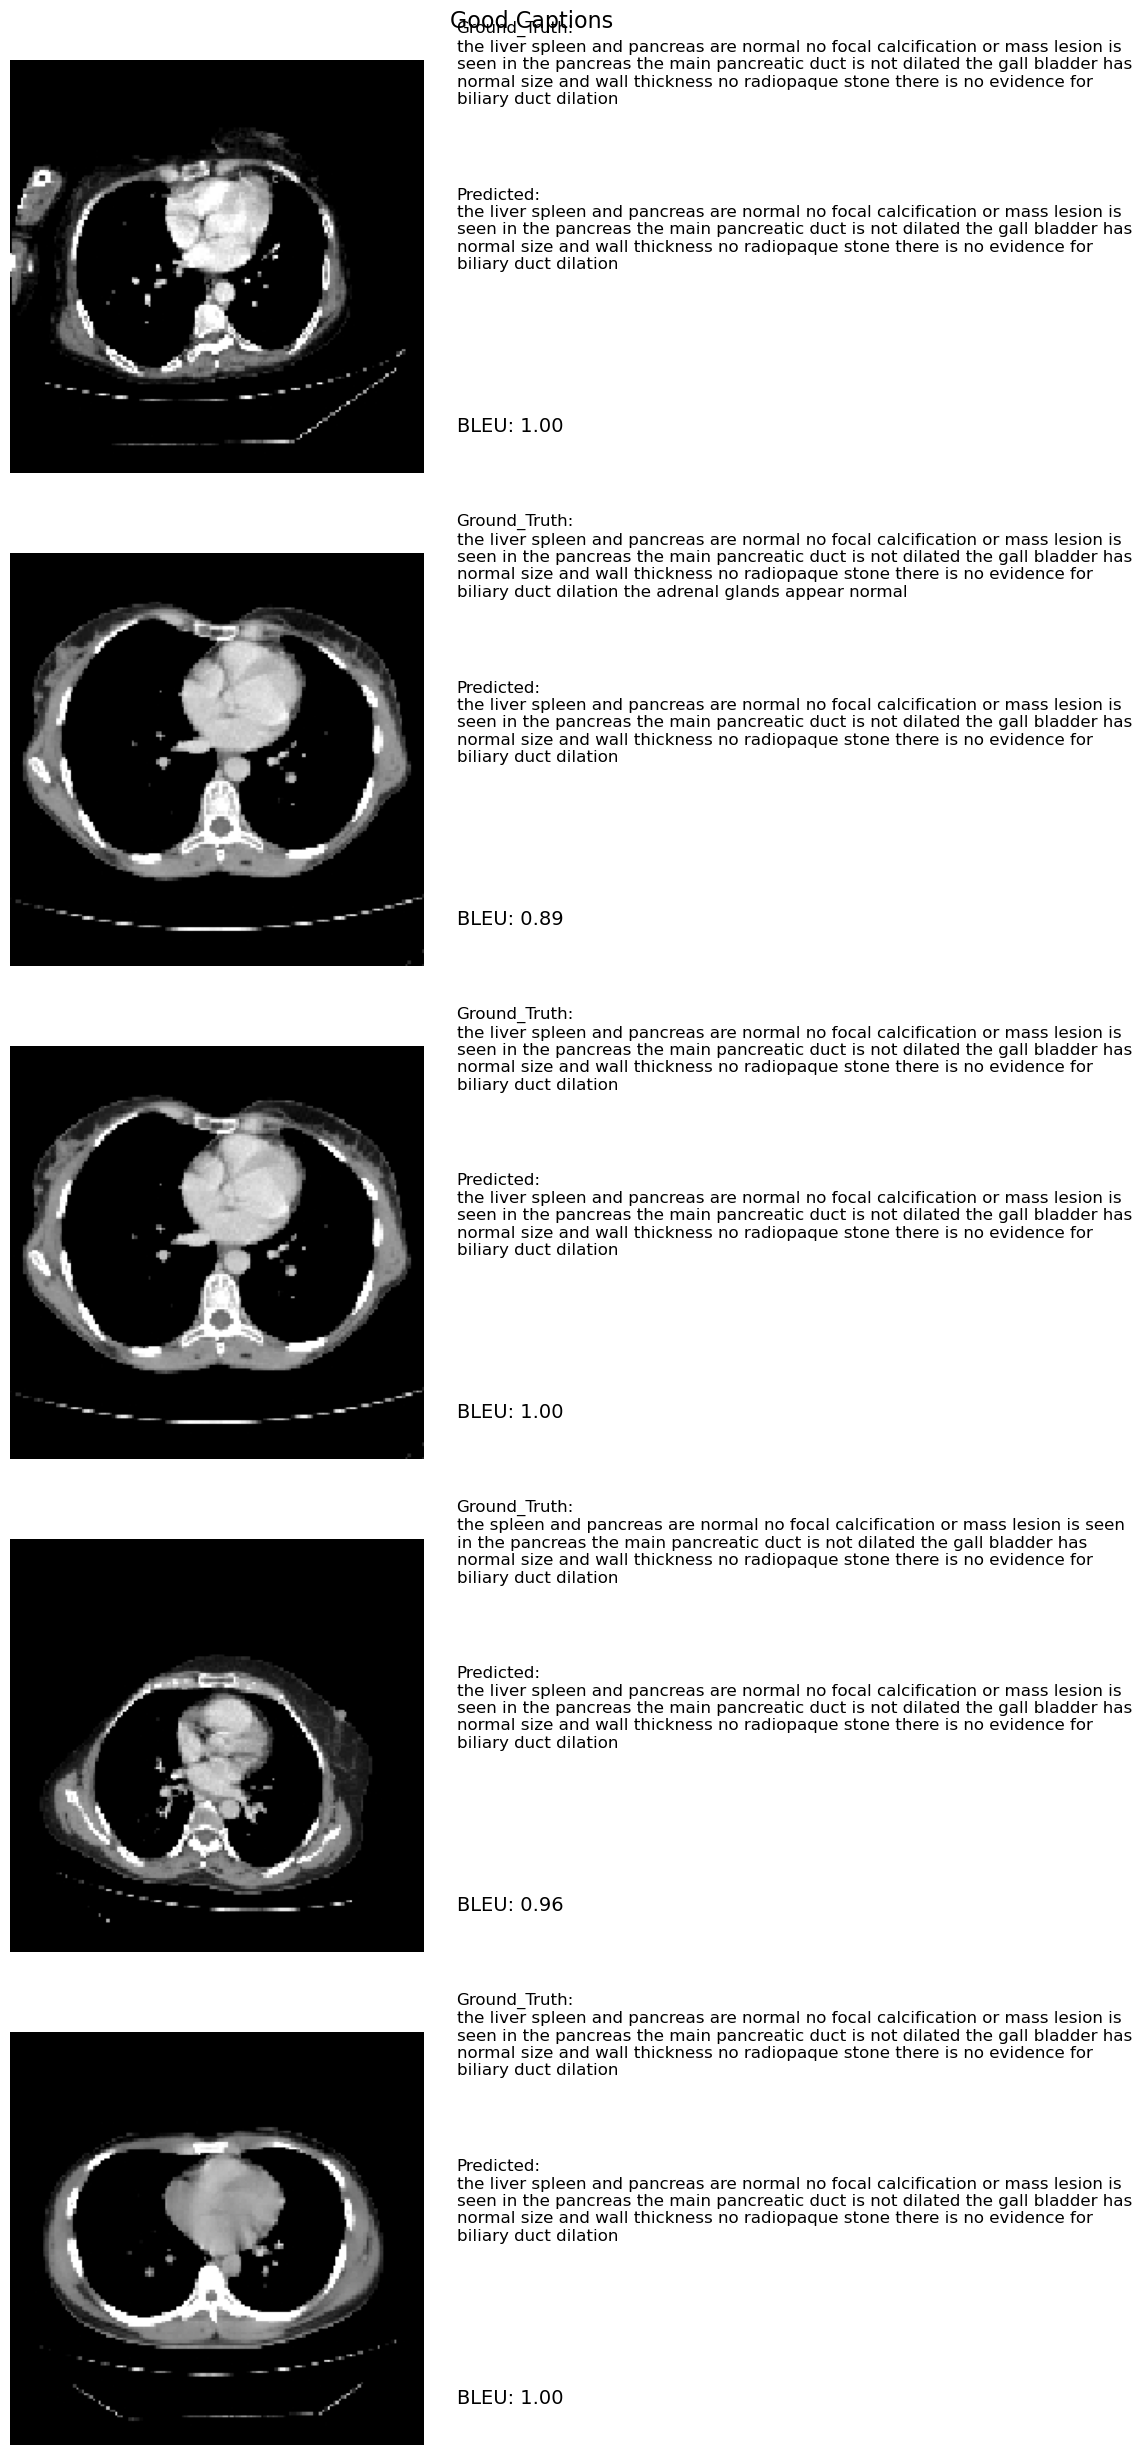

In [45]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

def plot_images(predictions, title="Captions"):
    def create_paragraph(captions):
        """Creates a paragraph by joining captions."""
        return " ".join(captions)
    
    npix = 224
    target_size = (npix, npix, 3)
    count = 0
    npic = len(predictions)
    
    # Create a figure with 2 columns: Image and Captions (Ground Truth & Predicted)
    fig, axes = plt.subplots(npic, 2, figsize=(12, npic * 5))
    
    for pb in predictions:
        bleu, jpgfnm, caption_true, caption_pred = pb
        
        # Load image
        filename = image_dir + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        
        # Display image in the first column
        ax_img = axes[count, 0]
        ax_img.imshow(image_load)
        ax_img.axis('off')  # Hide axis
        
        # Create caption paragraphs
        caption_true_paragraph = create_paragraph(caption_true)
        caption_pred_paragraph = create_paragraph(caption_pred)

        # Add text for Ground_Truth and Predicted in the second column
        ax_text = axes[count, 1]
        ax_text.axis('off')  # Hide axis for the text area
        ax_text.set_xlim(0, 1)
        ax_text.set_ylim(0, 1)

        # Display text (Ground_Truth, Predicted, and BLEU Score)
        ax_text.text(0, 0.9, f"Ground_Truth:\n{caption_true_paragraph}", fontsize=12, wrap=True)
        ax_text.text(0, 0.5, f"Predicted:\n{caption_pred_paragraph}", fontsize=12, wrap=True)
        ax_text.text(0, 0.1, f"BLEU: {bleu:.2f}", fontsize=14)

        count += 1

    # Set title and adjust layout
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# Display Bad Captions
print("Bad Captions")
plot_images(pred_bad, title="Bad Captions")

# Display Good Captions
print("Good Captions")
plot_images(pred_good, title="Good Captions")
